# SIN Anchors:


In [1]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict
from itertools import permutations

In [2]:
tablas = 8
n_grupo = 4

d = {}
D = "Dataset"
for i in range(0,tablas):
    d["group" + str(i)] = pd.read_excel("datasets.ods", sheet_name=D+str(i+1))
    print('Fichero leído:',i, 'tamaño', d["group" + str(i)].shape)

Fichero leído: 0 tamaño (227, 183)
Fichero leído: 1 tamaño (227, 183)
Fichero leído: 2 tamaño (227, 183)
Fichero leído: 3 tamaño (227, 183)
Fichero leído: 4 tamaño (227, 183)
Fichero leído: 5 tamaño (227, 183)
Fichero leído: 6 tamaño (227, 183)
Fichero leído: 7 tamaño (227, 183)


In [3]:
## Vamos a meter los Dataset en una hipermatriz M , donde cada capa es un dataset
rows = d["group" + str(i)].shape[0] - 3
columns = d["group" + str(i)].shape[1] - 3
#En el excel empieza en (5,4). Es decir una diferencia de 5 y 4 respecto a los números que saquemos


M = np.zeros((tablas,rows,columns))

for i in range(0, tablas):
    Data = d['group' + str(i)]
    M[i,:,:] = Data.iloc[3:,3:]

## No son cuadradas, pero puede que a mí me interese que lo sean (y llenar lo que sobre de ceros)
M_square = np.zeros((tablas, rows, rows))
M_square[:,:, 0:columns] = M[:,:,:]


#Lo queremos BINARIO, ignorando su peso (Luego pensar cómo se haría con el peso)
M_bin = np.zeros((tablas,rows,columns))
M_square_bin = np.zeros((tablas,rows,rows))
for i in range(tablas):
    for j in range(rows):
        for k in range(columns):
            if (M[i,j,k] >= 1):
                M_bin[i,j,k] = 1
                M_square_bin[i,j,k] = 1
                
Nx = rows
print('Filas:',rows)

Filas: 224


In [77]:
@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):
    n1 = int(Edges_L + alpha + beta - 2)
    k1 = overlap_1 + alpha -1
    
    n0 = int(Edges_NoL + alpha + beta - 2)
    k0 = overlap_0 + alpha - 1
    
    # !!!! Con numba los factoriales grandes dan errores: usar [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(n1+1)- math.lgamma(k1+1) - math.lgamma(n1-k1 +1) + math.log( Edges_L + alpha+beta-1)
    H0 = math.lgamma(n0+1)- math.lgamma(k0+1) - math.lgamma(n0-k0 +1) + math.log( Edges_NoL + alpha+beta-1)
    
    H = H1 + H0

    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K))
    ovlp_1 = np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): #Overlap de cada fila (pero no lo necesitamos guardar, solo queremos el total)
            for c in range(0,Nx):
            #El overlap depende de la permutación!
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])           
            
                if (L_f[f,c] == A_f[k,p_f,p_c]): #Antes tenía esto al revés
                    if (L_f[f,c] == 1):
                        ovlp_1[k] = ovlp_1[k]+1
                    else:
                        ovlp_0[k] = ovlp_0[k] +1

    ovlp_1 = int(sum(ovlp_1))
    ovlp_0 = int(sum(ovlp_0))
   
    return ovlp_0, ovlp_1


@jit(nopython=True)
def hamiltonian(Edges, overlap, alpha, beta):
    n = int(Edges+alpha+beta-2)
    k = overlap+alpha-1
    # !!!! Con numba los factoriales grandes dan errores: usar [ math.lgamma(n+1) == log(n!) ]
    H = math.lgamma(n+1)- math.lgamma(k+1) - math.lgamma(n-k+1) + math.log( Edges+alpha+beta-1)
    return H

@jit(nopython=True)
def deltaE(Edges, overlap, alpha, beta, delta_o):
    abs_o=abs(delta_o)
    logaritmo_b = 0  #Lo tengo que hacer por separad
    logaritmo_ab = 0
    
    A_max = Edges + alpha + beta -2 #Mirar pag 18 del cuaderno de bitácora
    B_max = overlap + delta_o + alpha -1

    if (delta_o<0):        
      
        logaritmo_b = math.lgamma((B_max + abs_o) + 1) - math.lgamma(B_max + 1)
        logaritmo_ab = math.lgamma(A_max - B_max +1) - math.lgamma(A_max - (B_max + abs_o)+1)
        logaritmo =  logaritmo_b - logaritmo_ab

        dE = logaritmo
        
    else:
        
        logaritmo_ab = math.lgamma(A_max - B_max + abs_o + 1) - math.lgamma(A_max - B_max + 1)
        logaritmo_b = math.lgamma(B_max + 1) - math.lgamma(B_max - abs_o + 1)   
        logaritmo = logaritmo_b - logaritmo_ab
        
        dE = -logaritmo   
        
    return dE 

@jit(nopython=True)
def overlap_total(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_f=np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): #Overlap de cada fila (pero no lo necesitamos guardar, solo queremos el total)
            for c in range(0,Nx):
            #El overlap depende de la permutación!
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])           
            
                if (L_f[f][c] == A_f[k,p_f,p_c]): #Antes tenía esto al revés
                    ovlp_f[k] = ovlp_f[k]+1

    ovlp_f=int(sum(ovlp_f))
   
    return ovlp_f

@jit(nopython=True)
def L_wiring(A_f, P_inv_f):
    
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
                #Necesito la permutación
                p1 = int(P_inv_f[k,i]) #A la fila y columna i de L, la fila y columna que le corresponde en A
                p2 = int(P_inv_f[k,j]) #A la fila y columna j de L, la fila y columna que le corresponde en A
                L_new_f[i,j] += A_f[k,p1,p2]
            
#             print('i,j', i,j,'L_new', L_new_)
            valor_lnew=1/K* L_new_f[i,j]
            if (valor_lnew!=0.5):#Para que el 0.5 no siempre me lo redondee hacia arriba o hacia abajo
                L_new_f[i,j] = round( valor_lnew )
            else:
                L_new_f[i,j] =np.random.randint(2)
            #MIRAR BOOLEANOS
            #L_new[i][j] = round( 1/K* L_new[i][j])*(L_new!=0.5)+np.random.randint(1)*(L_new==0.5) 

    #Recalculamiento de energia
    
    
    return L_new_f


#Este tiene en cuenta una lista secundaria
#(que puede ser por ejemplo el hub de mayor tamaño)
@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    #print('dentro:',array, begin, end)
    if end is None:
        end = len(array) - 1
    if begin >= end: #Para acabar el algoritmo
        return
    pivot = partition(array,  etiquetas, begin, end)
    #print('pivot', pivot, 'array', array)
    
    #Aquí ordenamos la derecha y la izquierda
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)
    
@njit 
#Vamos a ordenar igual las etiquetas de nodos con las de a que grupo pertenecen
def permu_groups(L_f, A_f, start_f): #En este caso no lo voy a hacer con anchors
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    
    #Matrices permutación y sus inversas
    P_f=np.zeros((K,Nx))
    P_inv_f=np.zeros((K,Nx))
    P_new=np.zeros((K,Nx))
    
    #Vamos a ordenar las matrices Observación según el grado de los nodos de L_inf
    orden_L=np.zeros((Nx))
    for i in range(Nx):
        b=np.nonzero(L_f[i,:])
        orden_L[i] = b[0].size#.size
        
    array_L = np.arange(Nx)
    quicksort(orden_L, array_L)
    #Luego para igualar el array_L con el array_A tenemos que tener en cuenta lo de labels_f
    
    #Ahora voy a hacer dos arrays_extras para colocar sus etiquetas
    #Cada grupo en orden
    #A_L_La=[#0, #1, #2, #3, #4,#5]
    array_L_labels = np.zeros((Nx))
    group_number = np.zeros((N_groups))
    for i in range(Nx):
        n_type = 0
        #Tenemos que ver a qué tipo pertenece
        while ( (array_L[i] >= start_f[n_type]) and (n_type < N_groups)):
            n_type += 1
       
        grupo = int(n_type-1)
        g = int(start_f[grupo])
        array_L_labels[g + int(group_number[grupo])] = array_L[i]
        group_number[grupo] += 1

    #Lo mismo para todas las A's
        
    #Órdenes de A
    for i in range(0,K):
        orden_A = np.zeros((Nx))
        for i_orden in range(Nx):
            b = np.nonzero(A_f[i,i_orden,:])
            orden_A[i_orden] = b[0].size

        array_A = np.arange(Nx) #Para las etiquetas
        quicksort(orden_A, array_A)
            
        ## Ahora empiezo a ordenarlos según el tipo 
        array_A_labels = np.zeros((Nx))
        group_number = np.zeros((N_groups))
        
        for i_g in range(Nx):
            n_type = 0
            #Tenemos que ver a qué tipo pertenece
            while ( (array_A[i_g] >= start_f[n_type]) and (n_type < N_groups) ):
                n_type += 1

            grupo = int(n_type-1)
            g = int(start_f[grupo])
            array_A_labels[ g + int(group_number[grupo])] = array_A[i_g]
            group_number[grupo] += 1
    

    # Ahora la permutación es ordenar array_L = [0,1,2,3...]
    # Y luego ordenar el array_A _labels según se haya ordenado el array_L_labels
        array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        P_f[i,:] = array_A_labels
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()

    
    
    return P_todo

@njit 
#Vamos a ordenar igual las etiquetas de nodos con las de a que grupo pertenecen
def random_groups(L_f, A_f, start_f, end_f): #En este caso no lo voy a hacer con anchors
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    
    #Matrices permutación y sus inversas
    P_f=np.zeros((K,Nx))
    P_inv_f=np.zeros((K,Nx))
    P_new=np.zeros((K,Nx))
    
    for i in range(0,K):
        for i_g in range(N_groups):
            start = start_f[i_g]
            end = end_f[i_g]
            
            ordenado = np.arange(start, end)
            np.random.shuffle(ordenado)
            P_f[i,start:end] = ordenado
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv

    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()

    
    
    return P_todo
#Vamos a ordenar igual las etiquetas de nodos con las de a que grupo pertenecen
def permu_groups_capa1_anchors_knwn(L_f, A_f, start_f,grupos_t, Anchors,grupos_extra): #En este caso no lo voy a hacer con anchors
   
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    start_2 = np.zeros((len(start_f)))
    start_2[1:] = np.cumsum(grupos_extra)[:-1]
    start_anchor = start_f - start_2   
    start_anchor = start_anchor.astype(int)
    
    #Matrices permutación y sus inversas
    P_f = np.zeros((K,Nx))
    P_inv_f = np.zeros((K,Nx))
    P_new = np.zeros((K,Nx))
    
    
    ### Colocamos primero los anchors
    n_an = len(Anchors)
    P_f[:,:n_an] = Anchors
    
    #Vamos a ordenar las matrices Observación según el grado de los nodos de L_inf
    orden_L_in = np.zeros((Nx-n_an ))
    array_L = np.zeros((Nx-n_an ))
    c_o = 0

    for i in range(Nx):
        if (i not in Anchors):
            b = np.nonzero(L_f[i,:])
            array_L[c_o] = i
            orden_L_in[c_o] = b[0].size
            c_o += 1
     
    orden_L = orden_L_in.copy()
    quicksort(orden_L, array_L)
    array_L = array_L[::-1]

    grupos_L = np.zeros((Nx-n_an))
    for  i_g in range(N_groups):
        start = start_anchor[i_g]
        if (i_g != N_groups-1):
            end = start_anchor[i_g+1]
        else:
            end = Nx-n_an
        grupos_L[start:end] = i_g
    grupos_L = grupos_L.astype(int)
    orden_L = orden_L_in.copy()
    quicksort(orden_L, grupos_L )
    grupos_L = grupos_L[::-1]
    print('array_L', np.sort(array_L)[:5])

    #Órdenes de A
    for i in range(0,K):
        orden_A_in = np.zeros((Nx- n_an))
        array_A = np.zeros((Nx-n_an))
        grupos_A = np.zeros((Nx-n_an))
        c_o = 0
        for i_orden in range(Nx):
            if (i_orden not in Anchors):
                b = np.nonzero(A_f[i,i_orden,:])
                array_A[c_o] = i_orden
                grupos_A[c_o] = grupos_t[i, i_orden]
                orden_A_in[c_o] = b[0].size#.size
                c_o += 1
        
        orden_A = orden_A_in.copy()
        quicksort(orden_A, array_A)  
        array_A = array_A[::-1]
        print('array_A', np.sort(array_A)[:5])

        orden_A = orden_A_in.copy()
        quicksort(orden_A, grupos_A)
        grupos_A = grupos_A[::-1]

        
        array_A_L = np.zeros((Nx - n_an))
        for i_n in range(Nx-n_an):
            if ((grupos_A[i_n] == grupos_L[i_n])):
                array_A_L[i_n] = array_A[i_n]
            else:
                # Busco el siguiente del mismo grupo y lo cambio
                count = 0
                for i_nn in range(i_n, Nx-n_an):
                    if ((grupos_A[i_nn] == grupos_L[i_n])): 
                        array_A_L[i_n] = array_A[i_nn]
                        #Cambio
                        array_A[i_nn] = array_A[i_n]
                        aux = grupos_A[i_nn]
                        grupos_A[i_nn] = grupos_A[i_n]
                        grupos_A[i_n] = aux
                        count = 1
                        break
        array_A_L = array_A_L[np.argsort(array_L)]
        P_f[i,n_an:] = array_A_L
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()

        

    
    
    return P_todo

# CONDICIONES INICIALES Y GRUPOS

Ahora es cuando vamos a poner los unkwons!

In [70]:
# Por ahora no las sé buscar en excell pero seguramente no sea difícil leer celdas
Sensory = 69-5 #0
Inter = 113-70 # 1
Motor = 155-114 #2
Modulatory = 184-156 #3
Muscle = 216-185 #4 
Others = 228-217 #5

size_groups = np.array([Sensory, Inter, Motor, Modulatory, Muscle, Others]) + 1 #Porque empezamos en cero
n_groups = len(size_groups)
start_groups = np.zeros(n_groups) #En que posición empieza cada grupo
end_groups = np.zeros(n_groups)


print('grupos: Sensory, Inter, Motor, Modulatory, Muscle, Other')
print('SIZE GROUPS:', size_groups)
#Para evitar trabajar con diccionarios (por NUMBA), vamos a hacer matrices 
# Cada matriz tiene el tamaño de la de mayor, pero luego las vamos cortando
rows_g, columns_g = size_groups.max(), size_groups.max()
G = np.zeros((tablas, n_groups, rows_g, columns_g))  #Aunque en las matrices G no voy a estar muy interesada
labels = np.zeros((rows))

size_suma = 0
start_groups[0] = 0

for i in range(n_groups):
    size = size_groups[i]
    if (i!=n_groups-1):
        start_groups[i+1] = int(size_suma + size)
    for i_label in range(size_suma, size + size_suma):
        labels[i_label] = i
        
    G[:,i, :size,  :size] = M_square[:, size_suma:(size + size_suma), size_suma :(size + size_suma)] 
    size_suma = size_suma + (size) 

    

g1 = int((start_groups[-2]))

for i in range(0,n_groups):
    if (i!= n_groups-1):
        end_groups[i] = start_groups[i+1]
    else:
        end_groups[i] = Nx
start_groups = start_groups.astype(int)
end_groups = end_groups.astype(int)

print('***********************************')
print('Primer nodo de cada grupo', start_groups)
print('Último nodo de cada grupo', end_groups)



grupos: Sensory, Inter, Motor, Modulatory, Muscle, Other
SIZE GROUPS: [65 44 42 29 32 12]
***********************************
Primer nodo de cada grupo [  0  65 109 151 180 212]
Último nodo de cada grupo [ 65 109 151 180 212 224]


## C-elegants

Cogemos los estadios más evolucionados: A2,A1, L4,L3

In [71]:
### DATOS
Nx, Ny = rows, rows #Nodos en la red
#Nx, Ny = rows, columns

qn = 0.9 #Prob copia de nodo
qe = 0.2 #Prob copia de edge
K = 4 #tablas #Matrices copiadas K
alpha,beta = 5,2 #Distribución beta que usamos
Edges = Nx*Ny #Entradas de la matriz de adjacency
micropasos = Edges*K #Para pasar por todas las posibilidades

np.random.seed( random.randint(1,1999) )
A = np.zeros((K,Nx,Ny))
A = M_square_bin[4:, :,:]
                
print('MATRICES OBSERVACIÓN')  
print(A.shape)
print(np.sum(A))
####################################
## CONDICIONES INICIALES ##
L_ini = np.zeros((Nx,Ny))
P_ini_0 = np.zeros((K,Nx))
P_inv_ini_0 = np.zeros((K,Nx))
L_ini = (A[0,:,:]).copy()

groups_ini = np.zeros((K,Nx))
for m1 in range(K):
    for i_g in range(n_groups):
        start = start_groups[i_g]
        end = end_groups[i_g]
        groups_ini[m1, start:end] = i_g

MATRICES OBSERVACIÓN
(4, 224, 224)
7428.0


In [72]:
P_inis = permu_groups(L_ini, A, start_groups)
P_inis = P_inis.astype(int)
P_ini_0 = (P_inis[0,:,:]).copy()#
P_inv_ini_0 = (P_inis[1,:,:]).copy()
print('*************************')
print(P_ini_0)

*************************
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
  108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
  126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
  144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
  162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
  180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
  198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
  216 217 218 219 220 221 222 223]
 [  4  46  55  41  44  53  23  35   8  49  54  16  

In [73]:
###  VOY A PONER UN VECTOR DE UNKWONS de Nx 
## ( y otro de entradas== K-1 o buscar np.where == K-1, por ahora busco pero no sé )
# En cada entrada pongo el número de capas con groups == 6
# cuando hago los cambios en los que se incluyen un unkwons resto y sumo. 
# Si alguno llega a ==  K-1 ---> y hay más de dos ---> propongo el cambio y veo si lo acepta

## Temperaturas



In [74]:
# LISTA DE TEMPERATURAS
beta_o = 1.03
total = 15
b_exp = np.linspace(-5,5,num = total)
temper = beta_o**b_exp
tempers = temper

# tempers = np.zeros((total+1))
# mitad = int(total/2)
# tempers[:mitad] = temper[:mitad]
# tempers[mitad] = 1.0000
# tempers[mitad+1:] = temper[mitad:]

# ### odd and even 
# total_i = total +1 
total_i = total
tempers_odd1 = np.arange(0,total_i-1,2, dtype = int)
tempers_odd2 = np.arange(1, total_i, 2,dtype = int)
tempers_odd = np.zeros((2, len(tempers_odd1)))
tempers_odd[0,:] = tempers_odd1
tempers_odd[1,:] = tempers_odd2
# print('Odd', tempers_odd)

tempers_even1 = np.arange(1,total_i,2)
tempers_even2 = np.arange(2, total_i, 2)
tempers_even = np.zeros((2, len(tempers_even1)))
tempers_even[0,:] = tempers_even1
tempers_even[1,:] = tempers_even2


print('betas:', tempers)
N_t = len(tempers)
        
P_ini_t = np.zeros((N_t,K,Nx))
P_inv_ini_t = np.zeros((N_t,K,Nx))
L_ini_t = np.zeros((N_t,Nx,Ny)) 
groups_ini_t = np.zeros((N_t, K, Nx ))

for i in range(0,N_t): #Aquí estoy inicializando para las temperaturas
    P_ini_t[i,:,:] = P_ini_0[:,:].copy()
    P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
    L_ini_t[i,:,:] = L_ini.copy()
    groups_ini_t[i,:,:] = groups_ini.copy()


betas: [0.86260878 0.88101504 0.89981405 0.91901419 0.93862401 0.95865228
 0.9791079  1.         1.0213379  1.0431311  1.06538932 1.08812249
 1.11134073 1.1350544  1.15927407]


# Funciones MonteCarlo: Parallel sampling

In [84]:
@jit(nopython=True)
def overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2,A_f, P_inv_old, i_change, j_change,pp1, pp2): 

    Nx = L_f_v1v2_old.shape[1]
    K = A_f.shape[0]
    
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
  
    #old and new: changes and mapping changes
    changes = np.array([i_change, j_change], dtype = np.int32)
    changes_p = np.array([pp1, pp2], dtype = np.int32)  
    changes_old = np.array([j_change, i_change], dtype = np.int32)
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)
    
    for i_k in range(K):
        for i_chan,change in enumerate(changes):
            for i_x in range(Nx):
                if (i_k != m1): # Only changes in the networks m1
                    p_f = int(P_inv_old[i_k,change])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                
                else:
                    p_f = changes_p[i_chan]
                    p_old = changes_p_old[i_chan]
                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else: # Only changes in the nodes i,j
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c

                ## rows
                valor_L_old, valor_A_old = L_f_v1v2_old[i_chan,i_x], A_f[i_k,p_old,p_old_c]   
                valor_L_new, valor_A_new = L_f_v1v2[i_chan,i_x], A_f[i_k,p_f,p_c]
                ## columns
                valor_L_old_c, valor_A_old_c = 0,0
                valor_L_new_c, valor_A_new_c = 0,0
                column = 0        
                if (i_x not in changes):
                    column = 1
                    valor_L_old_c, valor_A_old_c = L_c_v1v2_old[i_chan,i_x],A_f[i_k,p_old_c, p_old]
                    valor_L_new_c, valor_A_new_c = L_c_v1v2[i_chan,i_x], A_f[i_k,p_c,p_f]

                ovlp_1_old = ovlp_1_old + valor_L_old*valor_A_old + valor_L_old_c*valor_A_old_c*column
                ovlp_0_old = ovlp_0_old + (1-valor_L_old)*(1-valor_A_old) + (1-valor_L_old_c)*(1-valor_A_old_c)*column
                
                ovlp_1_new = ovlp_1_new + valor_L_new*valor_A_new + valor_L_new_c*valor_A_new_c*column
                ovlp_0_new = ovlp_0_new + (1-valor_L_new)*(1-valor_A_new) + (1-valor_L_new_c)*(1-valor_A_new_c)*column
                
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old
   
    return ovlp_0_def, ovlp_1_def
### Some functions that numba do not have
@njit
def concatenate_numba_sinrep(a,b):
    size_a, size_b = len(a), len(b)
    no_double = []
    for i_b in range(size_b):
        if b[i_b] in a:
            size_b = size_b-1
        else:
            no_double.append(b[i_b])
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = no_double
    
    return a

@njit
def concatenate_numba(a,b):
    size_a, size_b = len(a), len(b)
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = b 
    
    return c

@njit
def sum_numba(S):
    Nx = S.shape[0]
    Ny = S.shape[1]
    
    suma = 0
    for i_s in range(Nx):
        suma = suma + sum(S[i_s,:])
        
    return suma
@njit
def sum_numba_filas(S): # 2 dimensions
    Nx = S.shape[0]
    Ny = S.shape[1]
    suma = np.zeros((Nx))
    for i_s in range(Nx):
        suma_c = 0 # sum of the column
        for i_y in range(Ny):
            suma[i_s] = suma_c + S[i_y,i_s] 
        
    return suma

@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):

    A_1 = overlap_1 + alpha
    B_1 = (Edges_L - overlap_1 + beta)
    C_1 = Edges_L + alpha + beta
    
    A_0 = overlap_0 + alpha
    B_0 = (Edges_NoL - overlap_0 + beta)
    C_0 = Edges_NoL + alpha + beta
    
    #  [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(A_1)+ math.lgamma(B_1) - math.lgamma(C_1) 
    H0 = math.lgamma(A_0)+ math.lgamma(B_0) - math.lgamma(C_0) 
    
    H = -(H1 + H0)
    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K))
    ovlp_1 = np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): 
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])  
                
                valor_L, valor_A = L_f[f,c], A_f[k,p_f,p_c]
                
                ovlp_0[k] = ovlp_0[k] + (1-valor_L)*(1-valor_A )
                ovlp_1[k] = ovlp_1[k] + valor_L*valor_A
                
                
    ovlp_1 = int(sum(ovlp_1))
    ovlp_0 = int(sum(ovlp_0))
    return ovlp_0, ovlp_1


@jit(nopython=True) # The blueprint is the average of the observations (taking into account the mapping)  
def L_wiring(A_f, P_inv_f):
    
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
        
                p1 = int(P_inv_f[k,i]) # Mapping of the observations
                p2 = int(P_inv_f[k,j]) # Mapping of the observations
                L_new_f[i,j] += A_f[k,p1,p2]
            valor_lnew=1/K* L_new_f[i,j]
            L_new_f[i,j] = round( valor_lnew ) 
            # If valor_lnew = 0, L=0 (we could establish L=1, but it is more probable to not have a connection)
    
    return L_new_f


#### Some algorithm for sorting
@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    if begin >= end: #To end
        return
    pivot = partition(array,  etiquetas, begin, end)
    
    #Order right and left
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)
    
@njit 
# We inizialise the algorithm sorting by node degree, but also taking into account the group labels
def permu_groups(L_f, A_f, start_f): 
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    
    # Mappings
    P_f = np.zeros((K,Nx)) #Mapping from L to A
    P_inv_f = np.zeros((K,Nx)) #Mapping from A to L
    P_new = np.zeros((K,Nx))
    
    # First we order the blueprint and after the observations
    # Blueprint:
    orden_L=np.zeros((Nx))
    for i in range(Nx):
        b=np.nonzero(L_f[i,:])
        orden_L[i] = b[0].size
        
    array_L = np.arange(Nx) #For the labels 
    quicksort(orden_L, array_L)
    
    # Now according to the group label
    array_L_labels = np.zeros((Nx))
    group_number = np.zeros((N_groups))
    for i in range(Nx):
        n_type = 0
        #Group
        while ( (array_L[i] >= start_f[n_type]) and (n_type < N_groups)):
            n_type += 1
       
        grupo = int(n_type-1)
        g = int(start_f[grupo])
        array_L_labels[g + int(group_number[grupo])] = array_L[i]
        group_number[grupo] += 1

    #Observations: 
    for i in range(0,K):
        orden_A = np.zeros((Nx))
        for i_orden in range(Nx):
            b = np.nonzero(A_f[i,i_orden,:])
            orden_A[i_orden] = b[0].size

        array_A = np.arange(Nx) #For the labels 
        quicksort(orden_A, array_A)
            
        # Now according to the group label
        array_A_labels = np.zeros((Nx))
        group_number = np.zeros((N_groups))
        
        for i_g in range(Nx):
            n_type = 0
            while ( (array_A[i_g] >= start_f[n_type]) and (n_type < N_groups) ):
                n_type += 1

            grupo = int(n_type-1)
            g = int(start_f[grupo])
            array_A_labels[ g + int(group_number[grupo])] = array_A[i_g]
            group_number[grupo] += 1
    

    # Now ordered together both label array  array_L = [0,1,2,3...]
        array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        P_f[i,:] = array_A_labels
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy() 
    P_todo[1,:,:] = P_inv_f.copy()

    return P_todo

@njit 
# We inizialise the algorithm sorting by node degree, but also taking into account the group labels
def permu_groups_random(A_f, start_f, end_f): 
    Nx = A_f.shape[1]
    K = A_f.shape[0]
    n_groups = len(start_f)
    # Mappings
    P_f = np.zeros((K, Nx), dtype=np.int64)  # Mapping from L to A
    P_inv_f = np.zeros((K, Nx), dtype=np.int64)  # Mapping from A to L
    
    for i_g in range(n_groups):
        s, e = start_f[i_g], end_f[i_g]
        for i_k in range(K):
            vector = np.arange(s, e)
            np.random.shuffle(vector)  # Use numpy's shuffle function
            P_f[i_k, s:e] = vector
    
    # Compute inverse permutation
    for i_k in range(K):
        P_inv_f[i_k] = np.argsort(P_f[i_k])
    
    P_todo = np.stack((P_f, P_inv_f))
    return P_todo
def ground_state(A,K,Nx, alpha, beta):
    P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
    for k in range(0,K):
        for i in range(0,Nx):
            P_new[k,i]=i 
            P_inv_new[k,i]=i            
    L_new = np.zeros((Nx,Nx))
    L_new =  L_wiring(A, P_inv_new)
    
    Edges_sum = K*Nx*Nx
    Edges_L = K*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
    Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
    overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)
    
    Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)

    return P_new, P_inv_new, L_new, Energy_new

def initialization_random(A, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta):
    
    L_ini = A[0,:,:].copy() ## Inicialize to compute permutation ranked by node degree
    # P_inis = permu_groups(L_ini, A, start_groups)
    P_inis = permu_groups_random(A, start_groups, end_groups)
    P_inis = P_inis.astype(int)
    P_ini_0 = (P_inis[0,:,:]).copy() # Mapping L to A
    P_inv_ini_0 = (P_inis[1,:,:]).copy() # Mapping A to L
    ## Inizialitation of the system for each temperature, with the same mappings
    P_ini_t = np.zeros((N_t,K,Nx))
    P_inv_ini_t = np.zeros((N_t,K,Nx))
    L_ini_t = np.zeros((N_t,Nx,Nx)) 
    groups_ini_t = np.zeros((N_t, K, Nx ))
    n_groups = len(start_groups)

    groups_ini = np.zeros((K,Nx)) #Groups label
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[m1, start:end] = i_g
    
        
    
    for i in range(0,N_t): 
        P_ini_t[i,:,:] = P_ini_0[:,:].copy()
        P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
        L_ini_t[i,:,:] = L_ini.copy()
        groups_ini_t[i,:,:] = groups_ini.copy()
    P_t = np.zeros((N_t,K,Nx))
    P_inv_t = np.zeros((N_t,K,Nx))
    L_t = np.zeros((N_t,Nx, Nx))

    P_t = (P_ini_t).copy()
    P_inv_t = (P_inv_ini_t).copy()
    groups_t = groups_ini_t.copy()


    Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
    Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
    ovlp_t0, ovlp_t1 = np.zeros((N_t)) , np.zeros((N_t)) 
    suma_L_t = np.zeros(N_t)

    ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
    P_t = P_t.astype(int)
    P_inv_t = P_inv_t.astype(int)
    L_t = L_t.astype(int)
    groups_t = groups_t.astype(int)
    
    #### Now the Blueprint is averaged
    Edges_sum = K*Nx*Nx
    for k_nt in range(N_t):
        L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
        Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
        Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
        overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
        Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
        ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
        suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
    

    
    return P_t, P_inv_t, L_t, Edges_L_t,Edges_NoL_t, Energy_t, ovlp_t0,ovlp_t1, suma_L_t,groups_t 
def initialization(A, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta):
    
    L_ini = A[0,:,:].copy() ## Inicialize to compute permutation ranked by node degree
    P_inis = permu_groups(L_ini, A, start_groups)
    # P_inis = permu_groups_random(A, start_groups, end_groups)
    P_inis = P_inis.astype(int)
    P_ini_0 = (P_inis[0,:,:]).copy() # Mapping L to A
    P_inv_ini_0 = (P_inis[1,:,:]).copy() # Mapping A to L
    ## Inizialitation of the system for each temperature, with the same mappings
    P_ini_t = np.zeros((N_t,K,Nx))
    P_inv_ini_t = np.zeros((N_t,K,Nx))
    L_ini_t = np.zeros((N_t,Nx,Nx)) 
    groups_ini_t = np.zeros((N_t, K, Nx ))
    n_groups = len(start_groups)

    groups_ini = np.zeros((K,Nx)) #Groups label
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[m1, start:end] = i_g
    
        
    
    for i in range(0,N_t): 
        P_ini_t[i,:,:] = P_ini_0[:,:].copy()
        P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
        L_ini_t[i,:,:] = L_ini.copy()
        groups_ini_t[i,:,:] = groups_ini.copy()
    P_t = np.zeros((N_t,K,Nx))
    P_inv_t = np.zeros((N_t,K,Nx))
    L_t = np.zeros((N_t,Nx, Nx))

    P_t = (P_ini_t).copy()
    P_inv_t = (P_inv_ini_t).copy()
    groups_t = groups_ini_t.copy()


    Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
    Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
    ovlp_t0, ovlp_t1 = np.zeros((N_t)) , np.zeros((N_t)) 
    suma_L_t = np.zeros(N_t)

    ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
    P_t = P_t.astype(int)
    P_inv_t = P_inv_t.astype(int)
    L_t = L_t.astype(int)
    groups_t = groups_t.astype(int)
    
    #### Now the Blueprint is averaged
    Edges_sum = K*Nx*Nx
    for k_nt in range(N_t):
        L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
        Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
        Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
        overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
        Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
        ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
        suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
    

    
    return P_t, P_inv_t, L_t, Edges_L_t,Edges_NoL_t, Energy_t, ovlp_t0,ovlp_t1, suma_L_t,groups_t 
def initialization_continuation(A, P_inv_t, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta):
    
    
    ## recalculo la L_t
    P_inv_ini = P_inv_t.copy()
    L_ini = np.zeros((N_t, Nx, Nx))
    P_ini = np.zeros((P_inv_t.shape))
    Edges_L_ini, Edges_NoL_ini = np.zeros((N_t)), np.zeros((N_t))
    Energy_ini, suma_L_ini = np.zeros((N_t)), np.zeros((N_t))
    overlap_0_ini, overlap_1_ini = np.zeros((N_t)), np.zeros((N_t))
    for k_nt in range(N_t):
        for i_k in range(K):
            P_ini[k_nt, i_k,:] = np.argsort(P_inv_ini[k_nt, i_k,:])

        L_ini[k_nt, :,:] =  L_wiring(A,P_inv_ini[k_nt, :,:])

        Edges_sum = K*Nx*Nx
        Edges_L_ini[k_nt] = K*(sum(sum(L_ini[k_nt, :,:]))) # Los edges=1 que tiene la matriz A
        Edges_NoL_ini[k_nt] = Edges_sum - Edges_L_ini[k_nt] #Los edges=0 que tiene la matriz A
        overlap_0_ini[k_nt], overlap_1_ini[k_nt] = overlap_total_prob(L_ini[k_nt, :,:],A,P_inv_ini[k_nt, :,:])     
        Energy_ini[k_nt] = hamiltonian_prob(Edges_NoL_ini[k_nt], Edges_L_ini[k_nt], overlap_0_ini[k_nt], overlap_1_ini[k_nt], alpha, beta)
        suma_L_ini[k_nt] = sum_numba(L_ini[k_nt,:,:])
    
    
    groups_ini = np.zeros((N_t, K, Nx ))
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[:,m1, start:end] = i_g
    
    overlap_0_ini, overlap_1_ini = overlap_0_ini.astype(int), overlap_1_ini.astype(int)
    P_ini = P_ini.astype(int)
    P_inv_ini = P_inv_ini.astype(int)
    L_ini = L_ini.astype(int)
    groups_ini = groups_ini.astype(int)
    
    return P_ini, P_inv_ini, L_ini, Edges_L_ini,Edges_NoL_ini, Energy_ini, overlap_0_ini, overlap_1_ini,suma_L_ini, groups_ini

def initialization_anchors(A, start_groups,end_groups,groups_ini, start_anchor,end_anchor,Anchors,grupos_extra, K, Nx, N_t, tempers, alpha, beta):
    
    L_ini = A[0,:,:].copy() ## Inicialize to compute permutation ranked by node degree
    P_inis = permu_groups_capa1_anchors_knwn(L_ini, A, start_groups,end_groups,start_anchor,end_anchor,groups_ini, Anchors, grupos_extra) 
    # P_inis = permu_groups_random(A, start_groups, end_groups)
    P_inis = P_inis.astype(int)
    P_ini_0 = (P_inis[0,:,:]).copy() # Mapping L to A
    P_inv_ini_0 = (P_inis[1,:,:]).copy() # Mapping A to L
    ## Inizialitation of the system for each temperature, with the same mappings
    P_ini_t = np.zeros((N_t,K,Nx))
    P_inv_ini_t = np.zeros((N_t,K,Nx))
    L_ini_t = np.zeros((N_t,Nx,Nx)) 
    groups_ini_t = np.zeros((N_t, K, Nx ))
    groups_anch_ini_t = np.zeros((N_t, K, Nx ))
    n_groups = len(start_groups)

    groups_ini = np.zeros((K,Nx)) #Groups label
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[m1, start:end] = i_g
    
    groups_ini_anchor = np.zeros((K,Nx))-1
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_anchor[i_g]
            end = end_anchor[i_g]
            groups_ini_anchor[m1, start:end] = i_g      
    
    for i in range(0,N_t): 
        P_ini_t[i,:,:] = P_ini_0[:,:].copy()
        P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
        L_ini_t[i,:,:] = L_ini.copy()
        groups_ini_t[i,:,:] = groups_ini.copy()
        groups_anch_ini_t[i,:,:] = groups_ini_anchor.copy()
        
    P_t = np.zeros((N_t,K,Nx))
    P_inv_t = np.zeros((N_t,K,Nx))
    L_t = np.zeros((N_t,Nx, Nx))

    P_t = (P_ini_t).copy()
    P_inv_t = (P_inv_ini_t).copy()
    groups_t = groups_ini_t.copy()
    groups_anch_t = groups_anch_ini_t.copy()

    Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
    Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
    ovlp_t0, ovlp_t1 = np.zeros((N_t)) , np.zeros((N_t)) 
    suma_L_t = np.zeros(N_t)

    ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
    P_t = P_t.astype(int)
    P_inv_t = P_inv_t.astype(int)
    L_t = L_t.astype(int)
    groups_t = groups_t.astype(int)
    groups_anch_t = groups_anch_t.astype(int)
    
    #### Now the Blueprint is averaged
    Edges_sum = K*Nx*Nx
    for k_nt in range(N_t):
        L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
        Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
        Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
        overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
        Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
        ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
        suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
    

    
    return P_t, P_inv_t, L_t, Edges_L_t,Edges_NoL_t, Energy_t, ovlp_t0,ovlp_t1, suma_L_t,groups_t, groups_anch_t
#Vamos a ordenar igual las etiquetas de nodos con las de a que grupo pertenecen
def permu_groups_capa1_anchors_knwn(L_f, A_f, start_f,end_f,start_anch_f,end_anch_f,grupos_t, Anchors,grupos_extra): #En este caso no lo voy a hacer con anchors
   
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    start_anchor = start_anch_f.copy()
    end_anchor = end_anch_f.copy()
    #Matrices permutación y sus inversas
    P_f = np.zeros((K,Nx))
    P_inv_f = np.zeros((K,Nx))
    P_new = np.zeros((K,Nx))
    
    
    ### Colocamos primero los anchors
    n_an = len(Anchors)
    P_inv_f[:,:n_an] = Anchors
    
    #Vamos a ordenar las matrices Observación según el grado de los nodos de L_inf
    orden_L_in = np.zeros((Nx-n_an ))
    array_L = np.zeros((Nx-n_an ))
    c_o = 0

    for i in range(Nx):
        if (i not in Anchors):
            b = np.nonzero(L_f[i,:])
            array_L[c_o] = i
            orden_L_in[c_o] = b[0].size
            c_o += 1
     
    orden_L = orden_L_in.copy()
    quicksort(orden_L, array_L)
    array_L = array_L[::-1]

    grupos_L = np.zeros((Nx-n_an))
    c_o = 0
    for  i_g in range(N_groups):
        for i_x in range(start_f[i_g], end_f[i_g]):
            if i_x not in Anchors:
                grupos_L[c_o] = i_g
                c_o += 1
    grupos_L = grupos_L.astype(int)
    orden_L = orden_L_in.copy()
    quicksort(orden_L, grupos_L )
    grupos_L = grupos_L[::-1]

    #Órdenes de A
    for i in range(0,K):
        orden_A_in = np.zeros((Nx- n_an))
        array_A = np.zeros((Nx-n_an))
        grupos_A = np.zeros((Nx-n_an))
        c_o = 0
        for i_orden in range(Nx):
            if (i_orden not in Anchors):
                b = np.nonzero(A_f[i,i_orden,:])
                array_A[c_o] = i_orden
                grupos_A[c_o] = grupos_t[i, i_orden]
                orden_A_in[c_o] = b[0].size#.size
                c_o += 1
        
        orden_A = orden_A_in.copy()
        quicksort(orden_A, array_A)  
        array_A = array_A[::-1]

        orden_A = orden_A_in.copy()
        quicksort(orden_A, grupos_A)
        grupos_A = grupos_A[::-1]

        
        array_A_L = np.zeros((Nx - n_an))
        for i_n in range(Nx-n_an):
            if ((grupos_A[i_n] == grupos_L[i_n])):
                array_A_L[i_n] = array_A[i_n]
            else:
                # Busco el siguiente del mismo grupo y lo cambio
                count = 0
                for i_nn in range(i_n, Nx-n_an):
                    if ((grupos_A[i_nn] == grupos_L[i_n])): 
                        array_A_L[i_n] = array_A[i_nn]
                        #Cambio
                        array_A[i_nn] = array_A[i_n]
                        aux = grupos_A[i_nn]
                        grupos_A[i_nn] = grupos_A[i_n]
                        grupos_A[i_n] = aux
                        count = 1
                        break
        array_A_L = array_A_L[np.argsort(array_L)]
        P_inv_f[i,n_an:] = array_A_L
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_inv_f[i,i_inv] == j_inv):
                    P_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()  
    
    return P_todo   

def variable_store(PasosMC,Pasos_store,N_epochs, N_t, K, Nx):
    energies_pasos = np.zeros((N_epochs,N_t,PasosMC))
    P_store = np.zeros((N_epochs,Pasos_store,N_t, K, Nx))
    Energy_store = np.zeros((N_epochs,Pasos_store, N_t))
    L_store = np.zeros((N_epochs,Pasos_store,N_t, Nx, Nx))
    return energies_pasos, P_store,L_store, Energy_store
@jit(nopython=True)
def L_wiring_change_filas(m1,L_old,A_f, i_change, j_change, P_inv_old):
    
    Nx = A_f.shape[1]
    K = A_f.shape[0] 
    
    L_new_f = L_old.copy()
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))
    
    ## changes
    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    
    ## Old values
    suma_old =(np.sum(L_old[i_change,:]) + np.sum(L_old[j_change,:]) + np.sum(L_old[:,i_change]) + np.sum(L_old[:,j_change]))-L_old[i_change,j_change]-L_old[j_change,j_change]-L_old[i_change,i_change]-L_old[j_change,i_change]
    
    ## New row and column
    L_new_f[i_change,:], L_new_f[j_change,:], L_new_f[:,i_change], L_new_f[:,j_change] = np.zeros(Nx),np.zeros(Nx),np.zeros(Nx),np.zeros(Nx)
    

    suma_1 = 0
    
    for i_i,i_chan in enumerate(changes): #Only looking at the 
        ############### ROWS & COLUMNS
        for i_x in range(Nx):
            if (i_x in changes): # The rest of nodes
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])
                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]

            else: # The nodes that change
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    
                    
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    
                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]
                    
                    
                    
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )

            valor_lnew_c=1/K* L_c_v1v2[i_i,i_x]
            L_c_v1v2[i_i,i_x] = round( valor_lnew_c)
                    
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    suma_1 = suma_new - suma_old
    return L_f_v1v2,L_c_v1v2, suma_1    

@jit(nopython=True)
def L_wiring_overlap_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,A_f, i_change, j_change, P_inv_old, pp1, pp2):
    
    Nx = A_f.shape[1]
    K = A_f.shape[0] 

    #### Para la parte del WIRING    
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))
    
    ## changes
    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    
    ## Old values
    suma_old =(np.sum(L_f_v1v2_old[0,:]) + np.sum(L_f_v1v2_old[1,:]) + np.sum(L_c_v1v2_old[0,:]) + np.sum(L_c_v1v2_old[1,:]))-L_f_v1v2_old[0,j_change]-L_f_v1v2_old[1,j_change]-L_f_v1v2_old[0,i_change]-L_f_v1v2_old[1,i_change]
    
    ## New row and column
    ##### Para la parte del OVERLAP
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
    changes_p = np.array([pp1, pp2], dtype = np.int32)  
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)
    suma_1 = 0
    
    for i_i,i_chan in enumerate(changes): #Only looking at the 
        ############### ROWS & COLUMNS
        for i_x in range(Nx):
            if (i_x in changes): # The rest of nodes
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])
                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]

            else: # The nodes that change
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    
                    
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    
                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]
                    
                    
                    
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )

            valor_lnew_c=1/K* L_c_v1v2[i_i,i_x]
            L_c_v1v2[i_i,i_x] = round( valor_lnew_c)
                    
            ## Una vez que tenemos los valores de la L podemos mirar el overlap!
            for i_k in range(K):
                if i_k != m1: # Only changes in m1
                    p_f = int(P_inv_old[i_k,i_chan])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                else:
                    p_f = changes_p[i_i]
                    p_old = changes_p_old[i_i]
                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else: # Only changes in the nodes i,j
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c
            
                valor_L_old, valor_A_old = L_f_v1v2_old[i_i,i_x], A_f[i_k,p_old,p_old_c]   
                valor_L_new, valor_A_new = L_f_v1v2[i_i,i_x], A_f[i_k,p_f,p_c]
                ## columns
                valor_L_old_c, valor_A_old_c = 0,0
                valor_L_new_c, valor_A_new_c = 0,0
                column = 0        
                if (i_x not in changes):
                    column = 1
                    valor_L_old_c, valor_A_old_c = L_c_v1v2_old[i_i,i_x],A_f[i_k,p_old_c, p_old]
                    valor_L_new_c, valor_A_new_c = L_c_v1v2[i_i,i_x], A_f[i_k,p_c,p_f]
    
                ovlp_1_old = ovlp_1_old + valor_L_old*valor_A_old + valor_L_old_c*valor_A_old_c*column
                ovlp_0_old = ovlp_0_old + (1-valor_L_old)*(1-valor_A_old) + (1-valor_L_old_c)*(1-valor_A_old_c)*column
                
                ovlp_1_new = ovlp_1_new + valor_L_new*valor_A_new + valor_L_new_c*valor_A_new_c*column
                ovlp_0_new = ovlp_0_new + (1-valor_L_new)*(1-valor_A_new) + (1-valor_L_new_c)*(1-valor_A_new_c)*column
                

    
                    
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    suma_1 = suma_new - suma_old

    ## Parte del overlap 
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old



    
    return L_f_v1v2,L_c_v1v2, suma_1, ovlp_0_def, ovlp_1_def

@jit(nopython = True)
def parallel_L_knwn_change_groups(c_parallel,alpha,beta,fijado_f,groups_f, N_groups_f, start_f, end_f,
                       A, P_t_f, P_inv_t_f, L_t_f,suma_L, Energy_t_f, ovlp_t_f0, ovlp_t_f1, tempers_f,tempers_odd, tempers_even,
                                    c_accep, c_odd, m_old, round_trip_old, c_rounds):
    
    # fijado_f : To let one of the networks fixed or not (If only two networks it doesn't matter)
    # c_parallel: counter to change temperatures
    # start_f, end,f
    # N_groups_f: Number of groups
    # groups_f: Directly the ggroup numbeer from the position
    ### Movement:
    # 1) Choose one node and see their group (also we can choose a group first)
    # 2) Choose another random node inside this group 
    # 3) Each 4 movements, we propose change the temperatures

    N_t = L_t_f.shape[0] # Numbers of tempers
    Nx = L_t_f.shape[1] # Numbers of nodes
    K = A.shape[0] # Numbers of networks
    Edges_sum = K*Nx*Nx
   
    if (c_parallel <4*Nx): # If not change of temperatures
        c_parallel += 1
        
        #Choose the networks to propose the change (in all temperatures)
        if (fijado_f == 1):
            m1 = np.random.randint(K-1)+1 #One networks
        else:
            m1 = np.random.randint(K)    
        
        for k_nt in range(N_t):    
            # 1) Choose a random node (node in A)
            v1_mapping = np.random.randint(0, Nx)
            grupo = groups_f[k_nt,m1,v1_mapping]
            start, end = start_f[grupo], end_f[grupo]
            size_group = end - start
            todos = size_group 
            if (size_group > 1): 
                v2_mapping = np.random.randint(start, end)
                while (v2_mapping == v1_mapping):
                    v2_mapping = np.random.randint(start, end)
    
                # Nodes in L
                v1 = P_t_f[k_nt, m1,v1_mapping]
                v2 = P_t_f[k_nt, m1, v2_mapping]
    
               ### Only changes in the specific columns and rows
                L_f_v1v2, L_f_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
                L_c_v1v2, L_c_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
    
                pp_1 = int(P_inv_t_f[k_nt,m1,v2]) # v2_mapping
                pp_2 = int(P_inv_t_f[k_nt,m1,v1]) # v1_mapping
    
                L_f_v1v2_old[0,:],L_f_v1v2_old[1,:] = L_t_f[k_nt,v1,:].copy(),L_t_f[k_nt,v2,:].copy()
                L_c_v1v2_old[0,:],L_c_v1v2_old[1,:] = L_t_f[k_nt,:,v1].copy(),L_t_f[k_nt,:,v2].copy()
                
                # Changes in the blueprint
                L_f_v1v2,L_c_v1v2 , suma_aux,ovl_0_new, ovl_1_new = L_wiring_overlap_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old, A, v1, v2, P_inv_t_f[k_nt,:,:], pp_1, pp_2)
                
                # Parameters to change
                Edges_L = K*(suma_L[k_nt] + suma_aux)
                Edges_NoL = Edges_sum - Edges_L
                overlap_0,overlap_1 = ovlp_t_f0[k_nt] + ovl_0_new, ovlp_t_f1[k_nt] + ovl_1_new
                Energy_bucle = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
                dE_sampler = Energy_bucle - Energy_t_f[k_nt]
                dE_t = dE_sampler
                ## borrar
                # if k_nt == 1:
                #     print(dE_t)
                ## borrar
                
                ### UPDATE
                if (dE_t < 0):
                    
                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1
    
                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1
    
                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:],L_f_v1v2[1,:]
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:],L_c_v1v2[1,:]
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux
    
                elif (np.random.rand() < np.exp(-dE_t*tempers_f[k_nt])):
    
                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1
    
                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1
    
                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:].copy(),L_f_v1v2[1,:].copy()
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:].copy(),L_c_v1v2[1,:].copy()
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux

    else: # Change in temperatures
        c_parallel = 0
        mt1 = np.random.randint(N_t) 
        if mt1 == 0:
            mt2 = 1
        elif mt1 == (N_t - 1):
            mt2 = mt1 -1
        else:
            mt2 = mt1 + random_menos_mas(np.random.rand())
        


        #Probar el cambio de energía
        #Cambio del 1:
        Energy_1 = Energy_t_f[mt1]
        #Cambio del 2:
        Energy_2 = Energy_t_f[mt2] 

        dE_parallel = -(tempers_f[mt1]-tempers_f[mt2])*(Energy_1-Energy_2)
        if (dE_parallel <0):#Se acepta directamente
            #Auxliar
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]
            #El 1 lo guardo en el 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()
            suma_L[mt1] = suma_L[mt2]
            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]

            #El 2 lo guardo en el 1 (que previamente lo he guardado bien)
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux
        elif (np.random.rand() < np.exp(-dE_parallel)):
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]
            #El 1 lo guardo en el 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()
            suma_L[mt1] = suma_L[mt2]
            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]

            #El 2 lo guardo en el 1 (que previamente lo he guardado bien)
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux
            
        # c_parallel = 0
        # if c_odd == 1:
        #     c_odd = 0
        #     mt1_tempers = tempers_odd[0,:]
        #     mt2_tempers = tempers_odd[1,:]

        # else:
        #     c_odd = 1
        #     mt1_tempers = tempers_even[0,:]
        #     mt2_tempers = tempers_even[1,:]

            
        # for mt1, mt2  in zip(mt1_tempers, mt2_tempers):
        
        #     #Probar el cambio de energía
        #     #Cambio del 1:
        #     Energy_1 = Energy_t_f[mt1]
        #     #Cambio del 2:
        #     Energy_2 = Energy_t_f[mt2] 

    
        #     dE_parallel = -(tempers_f[mt1]-tempers_f[mt2])*(Energy_1-Energy_2)
                
        #     if (dE_parallel <0):
        #         P_aux1 = (P_t_f[mt1, :, :]).copy()
        #         P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
        #         L_aux1 = (L_t_f[mt1,:,:]).copy()

        #         ovlp_aux0 = (ovlp_t_f0[mt1])
        #         ovlp_aux1 = (ovlp_t_f1[mt1])
        #         suma_aux = suma_L[mt1]

        #         # 1 --> 2
        #         Energy_t_f[mt1] = Energy_2
        #         P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
        #         P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
        #         L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()

        #         ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
        #         ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
        #         suma_L[mt1] = suma_L[mt2]

        #         # 2 --> 1
        #         Energy_t_f[mt2] = Energy_1
        #         P_t_f[mt2,:,:] = P_aux1
        #         P_inv_t_f[mt2,:,:] = P_inv_aux1
        #         L_t_f[mt2,:,:] = L_aux1

        #         ovlp_t_f0[mt2] = ovlp_aux0
        #         ovlp_t_f1[mt2] = ovlp_aux1
        #         suma_L[mt2] = suma_aux
                
        #         if m_old == mt1:
        #             m_old = mt2
        #         elif m_old == mt2:
        #             m_old = mt1
        #         if m_old == 0 and round_trip_old == -1:
        #             c_rounds += 1
        #             round_trip_old = 1
        #         elif m_old == (N_t -1) and round_trip_old == 1:
        #             c_rounds += 1
        #             rount_trip_old = -1
                    
                
                
        #         if tempers_f[mt1] == 1 or tempers_f[mt2] == 1:
        #             c_accep += 1

        #     elif (np.random.rand() < np.exp(-dE_parallel)):
        #         P_aux1 = (P_t_f[mt1, :, :]).copy()
        #         P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
        #         L_aux1 = (L_t_f[mt1,:,:]).copy()

        #         ovlp_aux0 = (ovlp_t_f0[mt1])
        #         ovlp_aux1 = (ovlp_t_f1[mt1])
        #         suma_aux = suma_L[mt1]

        #         # 1 --> 2
        #         Energy_t_f[mt1] = Energy_2
        #         P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
        #         P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
        #         L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()

        #         ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
        #         ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
        #         suma_L[mt1] = suma_L[mt2]

        #         # 2 --> 1
        #         Energy_t_f[mt2] = Energy_1
        #         P_t_f[mt2,:,:] = P_aux1
        #         P_inv_t_f[mt2,:,:] = P_inv_aux1
        #         L_t_f[mt2,:,:] = L_aux1

        #         ovlp_t_f0[mt2] = ovlp_aux0
        #         ovlp_t_f1[mt2] = ovlp_aux1
        #         suma_L[mt2] = suma_aux
                
        #         if m_old == mt1:
        #             m_old = mt2
        #         elif m_old == mt2:
        #             m_old = mt1
        #         if m_old == 0 and round_trip_old == -1:
        #             c_rounds += 1
        #             round_trip_old = 1
        #         elif m_old == (N_t -1) and round_trip_old == 1:
        #             c_rounds += 1
        #             round_trip_old = -1
                    
                
        #         if tempers_f[mt1] == 1 or tempers_f[mt2] == 1:
        #             c_accep += 1
    return c_parallel, P_t_f, P_inv_t_f,Energy_t_f, ovlp_t_f0, ovlp_t_f1, L_t_f, suma_L, c_accep, c_odd, m_old, round_trip_old, c_rounds


@njit
def custom_round(number):
    if number >= 0.5:
        return 1
    else:
        return 0

@njit
def random_menos_mas(number):
    if number >= 0.5:
        return 1
    else:
        return -1


# Iteraciones MC

In [85]:
parejas = 0 # Para saber si coger parejas o no
fijado = 0 # Para saber si fijar la primera red o no

In [86]:
for k in range(K):
    print(np.sum(A[k,:,:]))

1515.0
1525.0
2202.0
2186.0


In [95]:
P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
for k in range(0,K):
    for i in range(0,Nx):
        P_new[k,i]=i 
        P_inv_new[k,i]=i            
L_new = np.zeros((Nx,Ny)) #La propuesta de cambio
L_new =  L_wiring(A, P_inv_new)
print(np.sum(L_new))
Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energía con permutación de media de matrices:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')
E_gs = Energy_new


1267.0
Energía con permutación de media de matrices: 16019.663954670905
overlap_0: 192861 /overlap_1: 4653
%Overlaps: 98.41059470663265 %


In [104]:
np.random.seed( random.randint(1,1999) )

P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
for k in range(0,K):
    for i in range(0,Nx):
        P_new[k,i]=i 
        P_inv_new[k,i]=i            
L_new = np.zeros((Nx,Ny)) #La propuesta de cambio
L_new =  L_wiring(A, P_inv_new)

Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energía con permutación de media de matrices:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')

# Nuestro problema
ovlp_ini0, ovlp_ini1 = overlap_total_prob(L_ini,A,P_inv_ini_0)

# METIENDO LAS TEMPERATURAS
ovlp_ini0_t = np.zeros((N_t)) + ovlp_ini0
ovlp_ini1_t = np.zeros((N_t)) + ovlp_ini1
ovlp_ini0_t, ovlp_ini1_t = ovlp_ini0_t.astype(int), ovlp_ini1_t.astype(int)

P_t = np.zeros((N_t,K,Nx))
P_inv_t = np.zeros((N_t,K,Nx))
L_t = np.zeros((N_t,Nx, Ny))
Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
groups_t = np.zeros((N_t, K, Nx))


# Inicializamos
ovlp_t0, ovlp_t1 = np.zeros((N_t)) + ovlp_ini0, np.zeros((N_t)) + ovlp_ini1
P_t = (P_ini_t).copy()
P_inv_t = (P_inv_ini_t).copy()
L_t = (L_ini_t).copy()
groups_t = groups_ini_t.copy()
#Convertirlos en enteros
ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
P_t = P_t.astype(int)
P_inv_t = P_inv_t.astype(int)
L_t = L_t.astype(int)
groups_t = groups_t.astype(int)

## Vamos a guardar las aceptaciones
Edges_L = K*sum(sum(L_ini))
Edges_NoL = Edges_sum - Edges_L            
Energy_ini = hamiltonian_prob(Edges_NoL, Edges_L, ovlp_ini0, ovlp_ini1 ,alpha, beta)
Energy_ini_t = np.zeros((N_t))+ Energy_ini 
print()
print('Energía inicial:', Energy_ini)
print()


#######################################
start = time.time()
count_mc = 0
#### Bloque del wiring
for k_nt in range(N_t):
    L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
    Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
    ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
#####
print('Energía INICIAL TRAS WIRING:', Energy_t[0]) 
print('overlaps 0:', ovlp_t0[0], '1:', ovlp_t1[0])
print('%Overlaps:',100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')

print()
Energy_ini_wiring = Energy_t.copy()
############################################ MONTE CARLO
#Guardamos la energía
runs = 10
PasosMC = 16000
energies_pasos = np.zeros((runs,N_t,PasosMC))
energies_pasos[:,:,0] = Energy_ini_wiring
count_parallel, count_unl = 0, 0

# Guardamos configuraciones
Long_corr = 200
Pasos_corr = 8000
Pasos_store = int((PasosMC - Pasos_corr)/Long_corr)
if (Pasos_store<0):
    Pasos_store = 0
count_long, i_long = 0, 0 
P_store = np.zeros((runs,Pasos_store,N_t, K, Nx))
Energy_store = np.zeros((runs,Pasos_store, N_t))

i_count_micro,i_count_micro2 = 0,0

P_intermediate_shot = np.zeros((2,N_t,K,Nx))
E_intermediate_shot = np.zeros((2,N_t))
steps_middle_0 = 50
steps_middle_1 = 100

suma_L_t = np.zeros(N_t)
for k_nt in range(N_t):
    suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])

########################################################
L_run, Edges_L_run, Edges_noL_run, ov0_run, ov1_run, E_run, suma_run, P_run, P_inv_run = L_t.copy(), Edges_L_t.copy(), Edges_NoL_t.copy(), ovlp_t0.copy(), ovlp_t1.copy(), Energy_t.copy(), suma_L_t.copy(),P_t.copy(), P_inv_t.copy()
Edges_L_run, Edges_noL_run, ov0_run, ov1_run = Edges_L_run.astype(int), Edges_noL_run.astype(int), ov0_run.astype(int), ov1_run.astype(int)

for i_epoch in range(runs):
    L_t, ovlp_t0, ovlp_t1, Energy_t,suma_L_t,P_t, P_inv_t = L_run.copy(), ov0_run.copy(), ov1_run.copy(), E_run.copy(), suma_run.copy(), P_run.copy(), P_inv_run.copy()
    i_long = 0
    c_accep, c_odd, c_rounds = 0,0,0
    m_old, round_trip_old = 0,1

    
    for i_mc in tqdm(range(0,PasosMC)):
    ### GUARDAR CONFIGURACIONES
        if (i_mc > Pasos_corr):
            count_long += 1
            if (count_long == Long_corr):
                count_long = 0
                P_store[i_epoch,i_long,:,:,:] = P_inv_t.copy()
                Energy_store[i_epoch,i_long,:] = Energy_t.copy()
                i_long += 1
                print('Step', i_mc, 'Energy (temper = 1):', Energy_t[np.where(tempers == 1)[0][0]])
        ### FIN GUARDAR CONFIGURACIONES 
        
        if (i_mc == steps_middle_0 ):
            P_intermediate_shot[0,:,:,:] = P_inv_t.copy()
            E_intermediate_shot[0,:] = Energy_t.copy()
            
        if (i_mc == steps_middle_1 ):
            P_intermediate_shot[1,:,:,:] = P_inv_t.copy()
            E_intermediate_shot[1,:] = Energy_t.copy()
            
         
        energies_pasos[i_epoch,:, i_mc] = Energy_t[:]
        # print(Energy_t)
        for i_micro in range(Nx):
            tempers_loop, tempers_odd_loop, tempers_even_loop =  tempers,tempers_odd, tempers_even
            tempers_odd_loop, tempers_even_loop =  tempers_odd_loop.astype(int), tempers_even_loop.astype(int)
            # print(tempers_loop.dtype, tempers_odd_loop.dtype, tempers_even_loop.dtype)
            count_parallel,P_t, P_inv_t, Energy_t, ovlp_t0, ovlp_t1, L_t,suma_L_t,c_accep, c_odd, m_old, round_trip_old, c_rounds = parallel_L_knwn_change_groups( count_parallel,alpha,beta,fijado,groups_t,n_groups, start_groups, 
                                                                                                     end_groups,  A, P_t, P_inv_t, L_t,suma_L_t, Energy_t, ovlp_t0, 
                                                                                                     ovlp_t1,tempers_loop, tempers_odd_loop, tempers_even_loop,c_accep, c_odd, m_old, round_trip_old, c_rounds)
print('Fin Energy_t', Energy_t[-1], 'Energy_gs', E_gs) 
print('c_accep', c_accep,'c_rounds',  c_rounds )


end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))  

x=np.arange( len(energies_pasos[0,0,:]) )




print("Elapsed (after compilation) = %s" % (end - start))  

Energy_calculada = np.zeros((N_t))
for k_nt in range(N_t):
    Edges_L= K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL = Edges_sum - Edges_L
#     print('Para t=', tempers[k_nt], 'Edges_L', Edges_L)
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_calculada[k_nt] = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
    
print('Energía final:', Energy_t, 'Calculada:', Energy_calculada) 
print('overlaps_0:', ovlp_t0[0], 'overlap_1:', ovlp_t1[0], '%overlaps totales:', 100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')



Energía con permutación de media de matrices: 16019.663954670905
overlap_0: 192861 /overlap_1: 4653
%Overlaps: 98.41059470663265 %

Energía inicial: 28535.85329274948

Energía INICIAL TRAS WIRING: 30986.88988929674
overlaps 0: 193183 1: 307
%Overlaps: 96.40565210459184 %



 51%|███████████████████▍                  | 8204/16000 [08:43<07:31, 17.27it/s]

Step 8200 Energy (temper = 1): 16466.67074613663


 53%|███████████████████▉                  | 8404/16000 [08:55<07:07, 17.76it/s]

Step 8400 Energy (temper = 1): 16377.816537569415


 54%|████████████████████▍                 | 8604/16000 [09:07<07:53, 15.61it/s]

Step 8600 Energy (temper = 1): 16461.250160280775


 55%|████████████████████▉                 | 8804/16000 [09:19<07:20, 16.32it/s]

Step 8800 Energy (temper = 1): 16475.588532594535


 56%|█████████████████████▍                | 9004/16000 [09:31<06:32, 17.83it/s]

Step 9000 Energy (temper = 1): 16469.23131932311


 58%|█████████████████████▊                | 9204/16000 [09:43<06:25, 17.64it/s]

Step 9200 Energy (temper = 1): 16470.463331269282


 59%|██████████████████████▎               | 9404/16000 [09:54<06:43, 16.33it/s]

Step 9400 Energy (temper = 1): 16473.0328723551


 60%|██████████████████████▊               | 9606/16000 [10:06<06:02, 17.61it/s]

Step 9600 Energy (temper = 1): 16467.96122721379


 61%|███████████████████████▎              | 9804/16000 [10:18<05:52, 17.57it/s]

Step 9800 Energy (temper = 1): 16464.138030486836


 63%|███████████████████████▏             | 10004/16000 [10:30<07:04, 14.11it/s]

Step 10000 Energy (temper = 1): 16352.079389194849


 64%|███████████████████████▌             | 10206/16000 [10:42<05:42, 16.93it/s]

Step 10200 Energy (temper = 1): 16344.48597319625


 65%|████████████████████████             | 10406/16000 [10:54<05:45, 16.18it/s]

Step 10400 Energy (temper = 1): 16361.259630982866


 66%|████████████████████████▌            | 10606/16000 [11:06<05:39, 15.87it/s]

Step 10600 Energy (temper = 1): 16318.598037310323


 68%|████████████████████████▉            | 10804/16000 [11:18<05:03, 17.11it/s]

Step 10800 Energy (temper = 1): 16351.126195894802


 69%|█████████████████████████▍           | 11002/16000 [11:30<05:53, 14.15it/s]

Step 11000 Energy (temper = 1): 16352.091834475941


 70%|█████████████████████████▉           | 11204/16000 [11:43<05:18, 15.06it/s]

Step 11200 Energy (temper = 1): 16352.091834475941


 71%|██████████████████████████▎          | 11404/16000 [11:54<04:21, 17.56it/s]

Step 11400 Energy (temper = 1): 16354.829956284098


 73%|██████████████████████████▊          | 11604/16000 [12:07<04:21, 16.80it/s]

Step 11600 Energy (temper = 1): 16316.333996925678


 74%|███████████████████████████▎         | 11806/16000 [12:20<04:20, 16.12it/s]

Step 11800 Energy (temper = 1): 16354.829956284098


 75%|███████████████████████████▊         | 12004/16000 [12:32<04:18, 15.48it/s]

Step 12000 Energy (temper = 1): 16352.091834475941


 76%|████████████████████████████▏        | 12204/16000 [12:44<03:30, 18.00it/s]

Step 12200 Energy (temper = 1): 16310.553311370095


 78%|████████████████████████████▋        | 12404/16000 [12:56<03:44, 16.02it/s]

Step 12400 Energy (temper = 1): 16351.126195894802


 79%|█████████████████████████████▏       | 12604/16000 [13:08<03:17, 17.17it/s]

Step 12600 Energy (temper = 1): 16355.77895875983


 80%|█████████████████████████████▌       | 12804/16000 [13:20<03:22, 15.77it/s]

Step 12800 Energy (temper = 1): 16351.126195894802


 81%|██████████████████████████████       | 13006/16000 [13:33<02:51, 17.45it/s]

Step 13000 Energy (temper = 1): 16352.091834475941


 83%|██████████████████████████████▌      | 13204/16000 [13:44<02:36, 17.83it/s]

Step 13200 Energy (temper = 1): 16351.126195894802


 84%|██████████████████████████████▉      | 13404/16000 [13:56<02:36, 16.61it/s]

Step 13400 Energy (temper = 1): 16352.091834475941


 85%|███████████████████████████████▍     | 13604/16000 [14:09<02:30, 15.87it/s]

Step 13600 Energy (temper = 1): 16444.723735502666


 86%|███████████████████████████████▉     | 13804/16000 [14:21<02:05, 17.51it/s]

Step 13800 Energy (temper = 1): 16351.126195894802


 88%|████████████████████████████████▍    | 14004/16000 [14:33<02:12, 15.09it/s]

Step 14000 Energy (temper = 1): 16352.091834475941


 89%|████████████████████████████████▊    | 14204/16000 [14:45<01:48, 16.57it/s]

Step 14200 Energy (temper = 1): 16345.654326486641


 90%|█████████████████████████████████▎   | 14404/16000 [14:58<01:44, 15.24it/s]

Step 14400 Energy (temper = 1): 16346.57032067344


 91%|█████████████████████████████████▊   | 14604/16000 [15:10<01:21, 17.06it/s]

Step 14600 Energy (temper = 1): 16341.963026727375


 93%|██████████████████████████████████▏  | 14804/16000 [15:22<01:12, 16.55it/s]

Step 14800 Energy (temper = 1): 16233.24411911489


 94%|██████████████████████████████████▋  | 15006/16000 [15:34<00:57, 17.40it/s]

Step 15000 Energy (temper = 1): 16323.551924851512


 95%|███████████████████████████████████▏ | 15204/16000 [15:46<00:48, 16.50it/s]

Step 15200 Energy (temper = 1): 16298.262414579767


 96%|███████████████████████████████████▋ | 15406/16000 [15:58<00:34, 17.22it/s]

Step 15400 Energy (temper = 1): 16290.728599773327


 98%|████████████████████████████████████ | 15606/16000 [16:10<00:23, 16.75it/s]

Step 15600 Energy (temper = 1): 16300.906463917257


 99%|████████████████████████████████████▌| 15804/16000 [16:22<00:12, 15.93it/s]

Step 15800 Energy (temper = 1): 16330.002444139129


 50%|███████████████████                   | 8004/16000 [07:43<07:47, 17.10it/s]

Step 8001 Energy (temper = 1): 16866.361741801877


 51%|███████████████████▍                  | 8204/16000 [07:54<07:15, 17.90it/s]

Step 8201 Energy (temper = 1): 16815.82127504362


 53%|███████████████████▉                  | 8404/16000 [08:06<07:23, 17.12it/s]

Step 8401 Energy (temper = 1): 16860.268226048487


 54%|████████████████████▍                 | 8606/16000 [08:17<07:13, 17.07it/s]

Step 8601 Energy (temper = 1): 16860.268226048487


 55%|████████████████████▉                 | 8804/16000 [08:29<06:48, 17.62it/s]

Step 8801 Energy (temper = 1): 16814.256631071818


 56%|█████████████████████▍                | 9004/16000 [08:40<06:24, 18.22it/s]

Step 9001 Energy (temper = 1): 16770.949159386088


 58%|█████████████████████▊                | 9204/16000 [08:52<07:19, 15.46it/s]

Step 9201 Energy (temper = 1): 16813.196637553374


 59%|██████████████████████▎               | 9404/16000 [09:03<06:16, 17.50it/s]

Step 9401 Energy (temper = 1): 16826.954298711957


 60%|██████████████████████▊               | 9606/16000 [09:15<05:57, 17.88it/s]

Step 9601 Energy (temper = 1): 16770.949159386088


 61%|███████████████████████▎              | 9804/16000 [09:26<05:55, 17.44it/s]

Step 9801 Energy (temper = 1): 16770.075509631162


 63%|███████████████████████▏             | 10004/16000 [09:38<05:28, 18.26it/s]

Step 10001 Energy (temper = 1): 16772.465246045365


 64%|███████████████████████▌             | 10206/16000 [09:49<05:17, 18.24it/s]

Step 10201 Energy (temper = 1): 16862.70499567243


 65%|████████████████████████             | 10406/16000 [10:00<05:07, 18.22it/s]

Step 10401 Energy (temper = 1): 16838.112293520928


 66%|████████████████████████▌            | 10604/16000 [10:12<05:01, 17.89it/s]

Step 10601 Energy (temper = 1): 16838.809372116724


 68%|████████████████████████▉            | 10804/16000 [10:23<04:50, 17.90it/s]

Step 10801 Energy (temper = 1): 16820.606703170284


 69%|█████████████████████████▍           | 11006/16000 [10:34<04:38, 17.96it/s]

Step 11001 Energy (temper = 1): 16822.417271127422


 70%|█████████████████████████▉           | 11204/16000 [10:45<04:21, 18.37it/s]

Step 11201 Energy (temper = 1): 16813.196637553374


 71%|██████████████████████████▎          | 11404/16000 [10:57<04:31, 16.95it/s]

Step 11401 Energy (temper = 1): 16813.196637553374


 73%|██████████████████████████▊          | 11606/16000 [11:09<04:24, 16.64it/s]

Step 11601 Energy (temper = 1): 16818.431609681866


 74%|███████████████████████████▎         | 11804/16000 [11:20<03:51, 18.13it/s]

Step 11801 Energy (temper = 1): 16822.15841368807


 75%|███████████████████████████▊         | 12004/16000 [11:31<03:38, 18.30it/s]

Step 12001 Energy (temper = 1): 16822.55788003846


 76%|████████████████████████████▏        | 12208/16000 [11:43<03:29, 18.08it/s]

Step 12201 Energy (temper = 1): 16822.55788003846


 78%|████████████████████████████▋        | 12404/16000 [11:54<03:19, 18.01it/s]

Step 12401 Energy (temper = 1): 16817.40463261342


 79%|█████████████████████████████▏       | 12604/16000 [12:06<03:27, 16.37it/s]

Step 12601 Energy (temper = 1): 16817.40463261342


 80%|█████████████████████████████▌       | 12804/16000 [12:17<03:02, 17.55it/s]

Step 12801 Energy (temper = 1): 16800.88544957532


 81%|██████████████████████████████       | 13004/16000 [12:29<02:59, 16.67it/s]

Step 13001 Energy (temper = 1): 16762.316475436986


 83%|██████████████████████████████▌      | 13204/16000 [12:40<02:37, 17.75it/s]

Step 13201 Energy (temper = 1): 16810.55760365657


 84%|███████████████████████████████      | 13406/16000 [12:52<02:27, 17.56it/s]

Step 13401 Energy (temper = 1): 16809.48168460455


 85%|███████████████████████████████▍     | 13604/16000 [13:03<02:11, 18.16it/s]

Step 13601 Energy (temper = 1): 16802.032065816275


 86%|███████████████████████████████▉     | 13804/16000 [13:14<02:13, 16.48it/s]

Step 13801 Energy (temper = 1): 16804.629165834223


 88%|████████████████████████████████▍    | 14006/16000 [13:26<01:52, 17.72it/s]

Step 14001 Energy (temper = 1): 16808.366392030082


 89%|████████████████████████████████▊    | 14204/16000 [13:38<01:48, 16.61it/s]

Step 14201 Energy (temper = 1): 16803.459386585106


 90%|█████████████████████████████████▎   | 14404/16000 [13:50<01:30, 17.63it/s]

Step 14401 Energy (temper = 1): 16823.70916817437


 91%|█████████████████████████████████▊   | 14604/16000 [14:01<01:18, 17.83it/s]

Step 14601 Energy (temper = 1): 16804.629165834223


 93%|██████████████████████████████████▏  | 14804/16000 [14:12<01:07, 17.81it/s]

Step 14801 Energy (temper = 1): 16760.793103234944


 94%|██████████████████████████████████▋  | 15004/16000 [14:23<00:56, 17.74it/s]

Step 15001 Energy (temper = 1): 16826.160571715518


 95%|███████████████████████████████████▏ | 15204/16000 [14:35<00:43, 18.32it/s]

Step 15201 Energy (temper = 1): 16800.88544957532


 96%|███████████████████████████████████▋ | 15406/16000 [14:47<00:34, 17.42it/s]

Step 15401 Energy (temper = 1): 16804.629165834223


 98%|████████████████████████████████████ | 15606/16000 [14:59<00:24, 15.78it/s]

Step 15601 Energy (temper = 1): 16803.459386585106


 99%|████████████████████████████████████▌| 15804/16000 [15:10<00:11, 16.83it/s]

Step 15801 Energy (temper = 1): 16764.68973381105


 50%|███████████████████                   | 8006/16000 [07:43<07:37, 17.49it/s]

Step 8002 Energy (temper = 1): 16816.161775309425


 51%|███████████████████▍                  | 8206/16000 [07:54<07:13, 17.98it/s]

Step 8202 Energy (temper = 1): 16861.50562143029


 53%|███████████████████▉                  | 8406/16000 [08:06<07:04, 17.88it/s]

Step 8402 Energy (temper = 1): 16862.70499567243


 54%|████████████████████▍                 | 8606/16000 [08:17<07:00, 17.56it/s]

Step 8602 Energy (temper = 1): 16856.38750415579


 55%|████████████████████▉                 | 8806/16000 [08:28<06:42, 17.88it/s]

Step 8802 Energy (temper = 1): 16870.1886231268


 56%|█████████████████████▍                | 9006/16000 [08:40<06:56, 16.77it/s]

Step 9002 Energy (temper = 1): 16864.043867888788


 58%|█████████████████████▊                | 9206/16000 [08:52<06:33, 17.28it/s]

Step 9202 Energy (temper = 1): 16861.50562143029


 59%|██████████████████████▎               | 9406/16000 [09:03<06:44, 16.31it/s]

Step 9402 Energy (temper = 1): 16858.953529634673


 60%|██████████████████████▊               | 9606/16000 [09:15<05:59, 17.77it/s]

Step 9602 Energy (temper = 1): 16851.213293713314


 61%|███████████████████████▎              | 9806/16000 [09:26<05:42, 18.06it/s]

Step 9802 Energy (temper = 1): 16745.63295278061


 63%|███████████████████████▏             | 10008/16000 [09:38<05:55, 16.84it/s]

Step 10002 Energy (temper = 1): 16860.12995871932


 64%|███████████████████████▌             | 10206/16000 [09:49<05:48, 16.62it/s]

Step 10202 Energy (temper = 1): 16858.953529634673


 65%|████████████████████████             | 10406/16000 [10:01<05:14, 17.77it/s]

Step 10402 Energy (temper = 1): 16834.825349993902


 66%|████████████████████████▌            | 10606/16000 [10:13<05:10, 17.35it/s]

Step 10602 Energy (temper = 1): 16862.70499567243


 68%|████████████████████████▉            | 10806/16000 [10:25<04:51, 17.82it/s]

Step 10802 Energy (temper = 1): 16738.477068420027


 69%|█████████████████████████▍           | 11006/16000 [10:36<04:37, 18.00it/s]

Step 11002 Energy (temper = 1): 16731.29240076705


 70%|█████████████████████████▉           | 11206/16000 [10:48<04:32, 17.60it/s]

Step 11202 Energy (temper = 1): 16828.49310414165


 71%|██████████████████████████▍          | 11406/16000 [10:59<04:14, 18.08it/s]

Step 11402 Energy (temper = 1): 16856.38750415579


 73%|██████████████████████████▊          | 11606/16000 [11:11<04:17, 17.05it/s]

Step 11602 Energy (temper = 1): 16828.49310414165


 74%|███████████████████████████▎         | 11806/16000 [11:22<04:11, 16.66it/s]

Step 11802 Energy (temper = 1): 16856.38750415579


 75%|███████████████████████████▊         | 12006/16000 [11:34<03:48, 17.52it/s]

Step 12002 Energy (temper = 1): 16855.195660974205


 76%|████████████████████████████▏        | 12206/16000 [11:45<03:30, 18.01it/s]

Step 12202 Energy (temper = 1): 16832.215997493477


 78%|████████████████████████████▋        | 12408/16000 [11:57<03:30, 17.07it/s]

Step 12402 Energy (temper = 1): 16828.49310414165


 79%|█████████████████████████████▏       | 12606/16000 [12:09<03:11, 17.71it/s]

Step 12602 Energy (temper = 1): 16861.26771941453


 80%|█████████████████████████████▌       | 12806/16000 [12:20<03:00, 17.71it/s]

Step 12802 Energy (temper = 1): 16832.215997493477


 81%|██████████████████████████████       | 13008/16000 [12:32<02:45, 18.04it/s]

Step 13002 Energy (temper = 1): 16832.215997493477


 83%|██████████████████████████████▌      | 13206/16000 [12:43<02:44, 16.95it/s]

Step 13202 Energy (temper = 1): 16844.88330715964


 84%|███████████████████████████████      | 13406/16000 [12:55<02:29, 17.34it/s]

Step 13402 Energy (temper = 1): 16814.698280222932


 85%|███████████████████████████████▍     | 13606/16000 [13:07<02:12, 18.05it/s]

Step 13602 Energy (temper = 1): 16875.33273228412


 86%|███████████████████████████████▉     | 13808/16000 [13:18<02:02, 17.85it/s]

Step 13802 Energy (temper = 1): 16805.760152270894


 88%|████████████████████████████████▍    | 14006/16000 [13:30<01:54, 17.44it/s]

Step 14002 Energy (temper = 1): 16865.266040408234


 89%|████████████████████████████████▊    | 14206/16000 [13:41<01:52, 15.93it/s]

Step 14202 Energy (temper = 1): 16860.12995871932


 90%|█████████████████████████████████▎   | 14406/16000 [13:53<01:31, 17.39it/s]

Step 14402 Energy (temper = 1): 16862.70499567243


 91%|█████████████████████████████████▊   | 14606/16000 [14:04<01:18, 17.85it/s]

Step 14602 Energy (temper = 1): 16736.89074915555


 93%|██████████████████████████████████▏  | 14808/16000 [14:16<01:06, 17.97it/s]

Step 14802 Energy (temper = 1): 16734.888317325873


 94%|██████████████████████████████████▋  | 15006/16000 [14:27<00:56, 17.50it/s]

Step 15002 Energy (temper = 1): 16732.055633298012


 95%|███████████████████████████████████▏ | 15206/16000 [14:39<00:47, 16.70it/s]

Step 15202 Energy (temper = 1): 16858.953529634673


 96%|███████████████████████████████████▋ | 15406/16000 [14:51<00:44, 13.27it/s]

Step 15402 Energy (temper = 1): 16741.304173024553


 98%|████████████████████████████████████ | 15606/16000 [15:02<00:21, 18.18it/s]

Step 15602 Energy (temper = 1): 16746.063232291453


 99%|████████████████████████████████████▌| 15806/16000 [15:14<00:11, 17.62it/s]

Step 15802 Energy (temper = 1): 16738.477068420027


 50%|███████████████████                   | 8006/16000 [07:45<07:24, 17.97it/s]

Step 8003 Energy (temper = 1): 16524.53329802049


 51%|███████████████████▍                  | 8206/16000 [07:56<07:34, 17.14it/s]

Step 8203 Energy (temper = 1): 16519.71762871954


 53%|███████████████████▉                  | 8408/16000 [08:08<07:05, 17.83it/s]

Step 8403 Energy (temper = 1): 16517.07588365226


 54%|████████████████████▍                 | 8606/16000 [08:19<07:56, 15.51it/s]

Step 8603 Energy (temper = 1): 16524.95815405639


 55%|████████████████████▉                 | 8806/16000 [08:31<06:44, 17.79it/s]

Step 8803 Energy (temper = 1): 16526.095642337183


 56%|█████████████████████▍                | 9006/16000 [08:42<07:11, 16.21it/s]

Step 9003 Energy (temper = 1): 16532.471202466804


 58%|█████████████████████▊                | 9206/16000 [08:54<06:21, 17.83it/s]

Step 9203 Energy (temper = 1): 16519.71762871954


 59%|██████████████████████▎               | 9406/16000 [09:05<06:08, 17.87it/s]

Step 9403 Energy (temper = 1): 16640.389180020662


 60%|██████████████████████▊               | 9606/16000 [09:17<06:27, 16.52it/s]

Step 9603 Energy (temper = 1): 16520.80793889184


 61%|███████████████████████▎              | 9806/16000 [09:28<05:41, 18.11it/s]

Step 9803 Energy (temper = 1): 16524.53329802049


 63%|███████████████████████▏             | 10006/16000 [09:39<05:37, 17.77it/s]

Step 10003 Energy (temper = 1): 16518.142372092036


 64%|███████████████████████▌             | 10206/16000 [09:51<05:24, 17.87it/s]

Step 10203 Energy (temper = 1): 16517.07588365226


 65%|████████████████████████             | 10406/16000 [10:03<05:12, 17.91it/s]

Step 10403 Energy (temper = 1): 16518.142372092036


 66%|████████████████████████▌            | 10608/16000 [10:14<05:08, 17.46it/s]

Step 10603 Energy (temper = 1): 16520.80793889184


 68%|████████████████████████▉            | 10806/16000 [10:26<05:09, 16.79it/s]

Step 10803 Energy (temper = 1): 16520.80793889184


 69%|█████████████████████████▍           | 11006/16000 [10:37<04:38, 17.90it/s]

Step 11003 Energy (temper = 1): 16520.80793889184


 70%|█████████████████████████▉           | 11206/16000 [10:49<04:29, 17.78it/s]

Step 11203 Energy (temper = 1): 16649.171801506767


 71%|██████████████████████████▍          | 11406/16000 [11:00<04:19, 17.71it/s]

Step 11403 Energy (temper = 1): 16522.345021340945


 73%|██████████████████████████▊          | 11606/16000 [11:12<04:32, 16.10it/s]

Step 11603 Energy (temper = 1): 16524.53329802049


 74%|███████████████████████████▎         | 11806/16000 [11:23<03:54, 17.85it/s]

Step 11803 Energy (temper = 1): 16647.773626730523


 75%|███████████████████████████▊         | 12006/16000 [11:36<03:50, 17.31it/s]

Step 12003 Energy (temper = 1): 16522.868322620685


 76%|████████████████████████████▏        | 12206/16000 [11:47<03:37, 17.47it/s]

Step 12203 Energy (temper = 1): 16524.53329802049


 78%|████████████████████████████▋        | 12406/16000 [11:59<03:21, 17.85it/s]

Step 12403 Energy (temper = 1): 16518.142372092036


 79%|█████████████████████████████▏       | 12606/16000 [12:10<03:09, 17.89it/s]

Step 12603 Energy (temper = 1): 16520.80793889184


 80%|█████████████████████████████▌       | 12806/16000 [12:22<02:57, 18.02it/s]

Step 12803 Energy (temper = 1): 16518.587809422665


 81%|██████████████████████████████       | 13006/16000 [12:34<03:08, 15.85it/s]

Step 13003 Energy (temper = 1): 16517.07588365226


 83%|██████████████████████████████▌      | 13206/16000 [12:45<02:42, 17.20it/s]

Step 13203 Energy (temper = 1): 16517.07588365226


 84%|███████████████████████████████      | 13406/16000 [12:57<02:33, 16.92it/s]

Step 13403 Energy (temper = 1): 16517.07588365226


 85%|███████████████████████████████▍     | 13606/16000 [13:08<02:14, 17.77it/s]

Step 13603 Energy (temper = 1): 16518.142372092036


 86%|███████████████████████████████▉     | 13806/16000 [13:20<02:01, 18.04it/s]

Step 13803 Energy (temper = 1): 16518.142372092036


 88%|████████████████████████████████▍    | 14006/16000 [13:32<02:01, 16.46it/s]

Step 14003 Energy (temper = 1): 16517.07588365226


 89%|████████████████████████████████▊    | 14206/16000 [13:43<01:43, 17.29it/s]

Step 14203 Energy (temper = 1): 16515.46220167874


 90%|█████████████████████████████████▎   | 14406/16000 [13:55<01:28, 18.00it/s]

Step 14403 Energy (temper = 1): 16518.142372092036


 91%|█████████████████████████████████▊   | 14608/16000 [14:06<01:18, 17.82it/s]

Step 14603 Energy (temper = 1): 16524.53329802049


 93%|██████████████████████████████████▏  | 14806/16000 [14:17<01:06, 17.86it/s]

Step 14803 Energy (temper = 1): 16514.419692522504


 94%|██████████████████████████████████▋  | 15006/16000 [14:29<00:59, 16.67it/s]

Step 15003 Energy (temper = 1): 16519.71762871954


 95%|███████████████████████████████████▏ | 15206/16000 [14:40<00:44, 17.97it/s]

Step 15203 Energy (temper = 1): 16520.80793889184


 96%|███████████████████████████████████▋ | 15406/16000 [14:52<00:33, 17.91it/s]

Step 15403 Energy (temper = 1): 16515.46220167874


 98%|████████████████████████████████████ | 15606/16000 [15:04<00:22, 17.66it/s]

Step 15603 Energy (temper = 1): 16514.419692522504


 99%|████████████████████████████████████▌| 15806/16000 [15:15<00:11, 17.06it/s]

Step 15803 Energy (temper = 1): 16518.142372092036


 50%|███████████████████                   | 8008/16000 [07:43<07:17, 18.27it/s]

Step 8004 Energy (temper = 1): 16624.467114854408


 51%|███████████████████▍                  | 8210/16000 [07:55<07:24, 17.54it/s]

Step 8204 Energy (temper = 1): 16751.26925687155


 53%|███████████████████▉                  | 8408/16000 [08:06<07:03, 17.92it/s]

Step 8404 Energy (temper = 1): 16624.467114854408


 54%|████████████████████▍                 | 8608/16000 [08:18<06:47, 18.13it/s]

Step 8604 Energy (temper = 1): 16630.849791544846


 55%|████████████████████▉                 | 8808/16000 [08:29<07:32, 15.89it/s]

Step 8804 Energy (temper = 1): 16561.166254784715


 56%|█████████████████████▍                | 9008/16000 [08:41<06:51, 17.00it/s]

Step 9004 Energy (temper = 1): 16627.1459128739


 58%|█████████████████████▊                | 9208/16000 [08:52<06:33, 17.28it/s]

Step 9204 Energy (temper = 1): 16631.84911646488


 59%|██████████████████████▎               | 9408/16000 [09:04<06:08, 17.90it/s]

Step 9404 Energy (temper = 1): 16625.458455533386


 60%|██████████████████████▊               | 9608/16000 [09:15<06:33, 16.25it/s]

Step 9604 Energy (temper = 1): 16568.132293665512


 61%|███████████████████████▎              | 9808/16000 [09:27<06:21, 16.24it/s]

Step 9804 Energy (temper = 1): 16629.810093574233


 63%|███████████████████████▏             | 10008/16000 [09:39<05:54, 16.89it/s]

Step 10004 Energy (temper = 1): 16624.467114854408


 64%|███████████████████████▌             | 10208/16000 [09:50<05:39, 17.07it/s]

Step 10204 Energy (temper = 1): 16728.487097911362


 65%|████████████████████████             | 10408/16000 [10:02<05:47, 16.09it/s]

Step 10404 Energy (temper = 1): 16627.1459128739


 66%|████████████████████████▌            | 10608/16000 [10:13<05:09, 17.42it/s]

Step 10604 Energy (temper = 1): 16623.435307999243


 68%|████████████████████████▉            | 10810/16000 [10:25<05:00, 17.26it/s]

Step 10804 Energy (temper = 1): 16634.54691765451


 69%|█████████████████████████▍           | 11008/16000 [10:36<04:37, 17.98it/s]

Step 11004 Energy (temper = 1): 16626.090112523314


 70%|█████████████████████████▉           | 11208/16000 [10:48<04:26, 18.01it/s]

Step 11204 Energy (temper = 1): 16627.1459128739


 71%|██████████████████████████▍          | 11410/16000 [11:00<04:21, 17.56it/s]

Step 11404 Energy (temper = 1): 16623.435307999243


 73%|██████████████████████████▊          | 11608/16000 [11:11<04:13, 17.31it/s]

Step 11604 Energy (temper = 1): 16623.435307999243


 74%|███████████████████████████▎         | 11808/16000 [11:23<03:53, 17.91it/s]

Step 11804 Energy (temper = 1): 16561.166254784715


 75%|███████████████████████████▊         | 12008/16000 [11:34<03:42, 17.91it/s]

Step 12004 Energy (temper = 1): 16625.458455533386


 76%|████████████████████████████▏        | 12208/16000 [11:46<03:47, 16.65it/s]

Step 12204 Energy (temper = 1): 16563.63129135115


 78%|████████████████████████████▋        | 12408/16000 [11:57<03:20, 17.95it/s]

Step 12404 Energy (temper = 1): 16723.681617962975


 79%|█████████████████████████████▏       | 12608/16000 [12:09<03:15, 17.37it/s]

Step 12604 Energy (temper = 1): 16628.16151283218


 80%|█████████████████████████████▌       | 12808/16000 [12:20<03:38, 14.59it/s]

Step 12804 Energy (temper = 1): 16628.16151283218


 81%|██████████████████████████████       | 13008/16000 [12:32<03:09, 15.77it/s]

Step 13004 Energy (temper = 1): 16628.16151283218


 83%|██████████████████████████████▌      | 13208/16000 [12:44<02:38, 17.63it/s]

Step 13204 Energy (temper = 1): 16635.52989882711


 84%|███████████████████████████████      | 13408/16000 [12:56<02:24, 17.98it/s]

Step 13404 Energy (temper = 1): 16708.70415422621


 85%|███████████████████████████████▍     | 13608/16000 [13:08<02:20, 17.06it/s]

Step 13604 Energy (temper = 1): 16626.408884119526


 86%|███████████████████████████████▉     | 13808/16000 [13:20<02:04, 17.63it/s]

Step 13804 Energy (temper = 1): 16624.467114854408


 88%|████████████████████████████████▍    | 14010/16000 [13:31<01:52, 17.76it/s]

Step 14004 Energy (temper = 1): 16623.435307999243


 89%|████████████████████████████████▊    | 14208/16000 [13:43<01:43, 17.37it/s]

Step 14204 Energy (temper = 1): 16627.1459128739


 90%|█████████████████████████████████▎   | 14408/16000 [13:54<01:28, 17.99it/s]

Step 14404 Energy (temper = 1): 16629.810093574233


 91%|█████████████████████████████████▊   | 14608/16000 [14:06<01:18, 17.64it/s]

Step 14604 Energy (temper = 1): 16561.166254784715


 93%|██████████████████████████████████▏  | 14808/16000 [14:17<01:07, 17.63it/s]

Step 14804 Energy (temper = 1): 16623.435307999243


 94%|██████████████████████████████████▋  | 15008/16000 [14:29<00:55, 17.77it/s]

Step 15004 Energy (temper = 1): 16624.467114854408


 95%|███████████████████████████████████▏ | 15208/16000 [14:41<00:47, 16.62it/s]

Step 15204 Energy (temper = 1): 16626.090112523314


 96%|███████████████████████████████████▋ | 15408/16000 [14:52<00:34, 17.18it/s]

Step 15404 Energy (temper = 1): 16630.849791544846


 98%|████████████████████████████████████ | 15608/16000 [15:04<00:23, 16.81it/s]

Step 15604 Energy (temper = 1): 16633.72486162147


 99%|████████████████████████████████████▌| 15808/16000 [15:15<00:11, 16.89it/s]

Step 15804 Energy (temper = 1): 16639.203832764368


 50%|███████████████████                   | 8008/16000 [07:44<07:44, 17.21it/s]

Step 8005 Energy (temper = 1): 16325.241578488058


 51%|███████████████████▍                  | 8208/16000 [07:57<07:31, 17.25it/s]

Step 8205 Energy (temper = 1): 16324.418068642524


 53%|███████████████████▉                  | 8410/16000 [08:08<07:36, 16.62it/s]

Step 8405 Energy (temper = 1): 16322.64362356397


 54%|████████████████████▍                 | 8608/16000 [08:20<07:50, 15.71it/s]

Step 8605 Energy (temper = 1): 16325.393270823362


 55%|████████████████████▉                 | 8808/16000 [08:32<07:04, 16.96it/s]

Step 8805 Energy (temper = 1): 16256.06032338088


 56%|█████████████████████▍                | 9008/16000 [08:43<06:50, 17.03it/s]

Step 9005 Energy (temper = 1): 16328.87322240875


 58%|█████████████████████▊                | 9210/16000 [08:55<06:22, 17.76it/s]

Step 9205 Energy (temper = 1): 16324.418068642524


 59%|██████████████████████▎               | 9410/16000 [09:06<06:20, 17.33it/s]

Step 9405 Energy (temper = 1): 16331.708754216903


 60%|██████████████████████▊               | 9608/16000 [09:17<05:57, 17.88it/s]

Step 9605 Energy (temper = 1): 16314.303499958616


 61%|███████████████████████▎              | 9808/16000 [09:29<06:14, 16.54it/s]

Step 9805 Energy (temper = 1): 16318.771798733593


 63%|███████████████████████▏             | 10008/16000 [09:41<05:29, 18.17it/s]

Step 10005 Energy (temper = 1): 16328.0669937419


 64%|███████████████████████▌             | 10208/16000 [09:52<05:47, 16.65it/s]

Step 10205 Energy (temper = 1): 16331.708754216903


 65%|████████████████████████             | 10408/16000 [10:04<05:26, 17.15it/s]

Step 10405 Energy (temper = 1): 16265.381371964257


 66%|████████████████████████▌            | 10608/16000 [10:15<04:59, 17.99it/s]

Step 10605 Energy (temper = 1): 16328.0669937419


 68%|████████████████████████▉            | 10808/16000 [10:26<04:55, 17.58it/s]

Step 10805 Energy (temper = 1): 16336.450403179639


 69%|█████████████████████████▍           | 11008/16000 [10:38<04:59, 16.67it/s]

Step 11005 Energy (temper = 1): 16300.520408805736


 70%|█████████████████████████▉           | 11208/16000 [10:50<04:45, 16.80it/s]

Step 11205 Energy (temper = 1): 16314.303499958616


 71%|██████████████████████████▍          | 11408/16000 [11:01<04:46, 16.05it/s]

Step 11405 Energy (temper = 1): 16259.687298279096


 73%|██████████████████████████▊          | 11608/16000 [11:13<04:09, 17.62it/s]

Step 11605 Energy (temper = 1): 16245.944515682066


 74%|███████████████████████████▎         | 11808/16000 [11:25<04:02, 17.32it/s]

Step 11805 Energy (temper = 1): 16258.905026594643


 75%|███████████████████████████▊         | 12008/16000 [11:36<03:40, 18.07it/s]

Step 12005 Energy (temper = 1): 16258.905026594643


 76%|████████████████████████████▏        | 12208/16000 [11:48<03:30, 17.99it/s]

Step 12205 Energy (temper = 1): 16250.323493109703


 78%|████████████████████████████▋        | 12408/16000 [11:59<03:20, 17.91it/s]

Step 12405 Energy (temper = 1): 16246.709769663008


 79%|█████████████████████████████▏       | 12608/16000 [12:11<03:12, 17.65it/s]

Step 12605 Energy (temper = 1): 16317.098841299492


 80%|█████████████████████████████▌       | 12808/16000 [12:22<03:39, 14.51it/s]

Step 12805 Energy (temper = 1): 16249.575827137647


 81%|██████████████████████████████       | 13008/16000 [12:34<02:50, 17.58it/s]

Step 13005 Energy (temper = 1): 16250.749194422759


 83%|██████████████████████████████▌      | 13208/16000 [12:46<02:36, 17.89it/s]

Step 13205 Energy (temper = 1): 16249.575827137647


 84%|███████████████████████████████      | 13410/16000 [12:58<02:28, 17.45it/s]

Step 13405 Energy (temper = 1): 16241.479996980226


 85%|███████████████████████████████▍     | 13608/16000 [13:09<02:18, 17.28it/s]

Step 13605 Energy (temper = 1): 16243.827792605443


 86%|███████████████████████████████▉     | 13808/16000 [13:21<02:02, 17.93it/s]

Step 13805 Energy (temper = 1): 16312.299410758642


 88%|████████████████████████████████▍    | 14008/16000 [13:32<01:52, 17.67it/s]

Step 14005 Energy (temper = 1): 16242.305944823922


 89%|████████████████████████████████▊    | 14208/16000 [13:44<01:40, 17.87it/s]

Step 14205 Energy (temper = 1): 16345.44108441536


 90%|█████████████████████████████████▎   | 14408/16000 [13:55<01:27, 18.16it/s]

Step 14405 Energy (temper = 1): 16243.088709009877


 91%|█████████████████████████████████▊   | 14608/16000 [14:07<01:16, 18.15it/s]

Step 14605 Energy (temper = 1): 16243.827792605443


 93%|██████████████████████████████████▏  | 14808/16000 [14:18<01:08, 17.29it/s]

Step 14805 Energy (temper = 1): 16246.709769663008


 94%|██████████████████████████████████▋  | 15008/16000 [14:30<01:02, 15.82it/s]

Step 15005 Energy (temper = 1): 16317.956687757716


 95%|███████████████████████████████████▏ | 15208/16000 [14:41<00:44, 17.69it/s]

Step 15205 Energy (temper = 1): 16317.956687757716


 96%|███████████████████████████████████▋ | 15410/16000 [14:53<00:32, 17.91it/s]

Step 15405 Energy (temper = 1): 16245.135883061368


 98%|████████████████████████████████████ | 15608/16000 [15:04<00:22, 17.15it/s]

Step 15605 Energy (temper = 1): 16245.944515682066


 99%|████████████████████████████████████▌| 15808/16000 [15:16<00:10, 18.04it/s]

Step 15805 Energy (temper = 1): 16336.866590316706


 50%|███████████████████                   | 8010/16000 [07:43<07:27, 17.85it/s]

Step 8006 Energy (temper = 1): 16668.345423732295


 51%|███████████████████▍                  | 8210/16000 [07:55<08:06, 16.03it/s]

Step 8206 Energy (temper = 1): 16667.019560703295


 53%|███████████████████▉                  | 8410/16000 [08:07<07:11, 17.60it/s]

Step 8406 Energy (temper = 1): 16669.88234321894


 54%|████████████████████▍                 | 8610/16000 [08:18<06:51, 17.96it/s]

Step 8606 Energy (temper = 1): 16661.926390488974


 55%|████████████████████▉                 | 8810/16000 [08:29<06:50, 17.51it/s]

Step 8806 Energy (temper = 1): 16717.330896487736


 56%|█████████████████████▍                | 9010/16000 [08:41<06:41, 17.42it/s]

Step 9006 Energy (temper = 1): 16657.46980908575


 58%|█████████████████████▉                | 9212/16000 [08:53<06:25, 17.62it/s]

Step 9206 Energy (temper = 1): 16653.83053289947


 59%|██████████████████████▎               | 9412/16000 [09:04<06:54, 15.88it/s]

Step 9406 Energy (temper = 1): 16655.504763471894


 60%|██████████████████████▊               | 9612/16000 [09:15<06:34, 16.21it/s]

Step 9606 Energy (temper = 1): 16654.688838940267


 61%|███████████████████████▎              | 9810/16000 [09:27<05:46, 17.85it/s]

Step 9806 Energy (temper = 1): 16661.10206889837


 63%|███████████████████████▏             | 10012/16000 [09:38<05:32, 18.00it/s]

Step 10006 Energy (temper = 1): 16723.681617962975


 64%|███████████████████████▌             | 10210/16000 [09:50<06:15, 15.41it/s]

Step 10206 Energy (temper = 1): 16662.70794756514


 65%|████████████████████████             | 10410/16000 [10:01<05:29, 16.98it/s]

Step 10406 Energy (temper = 1): 16658.311160123005


 66%|████████████████████████▌            | 10610/16000 [10:13<05:19, 16.86it/s]

Step 10606 Energy (temper = 1): 16712.45829136882


 68%|████████████████████████▉            | 10810/16000 [10:25<05:12, 16.60it/s]

Step 10806 Energy (temper = 1): 16713.59895547235


 69%|█████████████████████████▍           | 11010/16000 [10:37<04:42, 17.64it/s]

Step 11006 Energy (temper = 1): 16680.213537696553


 70%|█████████████████████████▉           | 11210/16000 [10:48<04:59, 16.01it/s]

Step 11206 Energy (temper = 1): 16676.513598727688


 71%|██████████████████████████▍          | 11410/16000 [10:59<04:20, 17.61it/s]

Step 11406 Energy (temper = 1): 16661.926390488974


 73%|██████████████████████████▊          | 11610/16000 [11:11<04:15, 17.19it/s]

Step 11606 Energy (temper = 1): 16657.00751326268


 74%|███████████████████████████▎         | 11810/16000 [11:23<04:19, 16.18it/s]

Step 11806 Energy (temper = 1): 16663.446245782892


 75%|███████████████████████████▊         | 12010/16000 [11:35<03:49, 17.38it/s]

Step 12006 Energy (temper = 1): 16673.45866913641


 76%|████████████████████████████▏        | 12210/16000 [11:46<03:37, 17.45it/s]

Step 12206 Energy (temper = 1): 16659.865655400157


 78%|████████████████████████████▋        | 12410/16000 [11:58<03:44, 16.00it/s]

Step 12406 Energy (temper = 1): 16657.693334960488


 79%|█████████████████████████████▏       | 12610/16000 [12:10<03:40, 15.37it/s]

Step 12606 Energy (temper = 1): 16676.513598727688


 80%|█████████████████████████████▌       | 12810/16000 [12:22<03:09, 16.84it/s]

Step 12806 Energy (temper = 1): 16656.277820395175


 81%|██████████████████████████████       | 13010/16000 [12:34<02:48, 17.73it/s]

Step 13006 Energy (temper = 1): 16657.00751326268


 83%|██████████████████████████████▌      | 13210/16000 [12:45<02:34, 18.09it/s]

Step 13206 Energy (temper = 1): 16659.865655400157


 84%|███████████████████████████████      | 13412/16000 [12:57<02:22, 18.10it/s]

Step 13406 Energy (temper = 1): 16672.80694449522


 85%|███████████████████████████████▍     | 13610/16000 [13:08<02:16, 17.57it/s]

Step 13606 Energy (temper = 1): 16680.213537696553


 86%|███████████████████████████████▉     | 13810/16000 [13:19<02:02, 17.92it/s]

Step 13806 Energy (temper = 1): 16676.513598727688


 88%|████████████████████████████████▍    | 14010/16000 [13:31<01:51, 17.89it/s]

Step 14006 Energy (temper = 1): 16673.83767147058


 89%|████████████████████████████████▊    | 14210/16000 [13:42<01:38, 18.19it/s]

Step 14206 Energy (temper = 1): 16659.865655400157


 90%|█████████████████████████████████▎   | 14410/16000 [13:54<01:29, 17.79it/s]

Step 14406 Energy (temper = 1): 16676.513598727688


 91%|█████████████████████████████████▊   | 14610/16000 [14:06<01:18, 17.72it/s]

Step 14606 Energy (temper = 1): 16660.57780877252


 93%|██████████████████████████████████▏  | 14810/16000 [14:17<01:05, 18.09it/s]

Step 14806 Energy (temper = 1): 16696.021145803177


 94%|██████████████████████████████████▋  | 15010/16000 [14:29<00:57, 17.21it/s]

Step 15006 Energy (temper = 1): 16664.72728348338


 95%|███████████████████████████████████▏ | 15210/16000 [14:40<00:44, 17.87it/s]

Step 15206 Energy (temper = 1): 16677.528138930407


 96%|███████████████████████████████████▋ | 15410/16000 [14:52<00:33, 17.50it/s]

Step 15406 Energy (temper = 1): 16661.24588760463


 98%|████████████████████████████████████ | 15612/16000 [15:03<00:24, 15.86it/s]

Step 15606 Energy (temper = 1): 16676.513598727688


 99%|████████████████████████████████████▌| 15810/16000 [15:15<00:10, 18.01it/s]

Step 15806 Energy (temper = 1): 16677.528138930407


 50%|███████████████████                   | 8010/16000 [07:47<07:27, 17.84it/s]

Step 8007 Energy (temper = 1): 16438.2061324018


 51%|███████████████████▍                  | 8210/16000 [07:58<07:14, 17.91it/s]

Step 8207 Energy (temper = 1): 16362.216716676048


 53%|███████████████████▉                  | 8410/16000 [08:10<06:59, 18.10it/s]

Step 8407 Energy (temper = 1): 16364.95924399719


 54%|████████████████████▍                 | 8610/16000 [08:21<07:13, 17.04it/s]

Step 8607 Energy (temper = 1): 16443.03373638056


 55%|████████████████████▉                 | 8810/16000 [08:33<07:34, 15.81it/s]

Step 8807 Energy (temper = 1): 16363.132233974495


 56%|█████████████████████▍                | 9010/16000 [08:45<06:35, 17.66it/s]

Step 9007 Energy (temper = 1): 16493.548270199644


 58%|█████████████████████▊                | 9210/16000 [08:56<07:05, 15.95it/s]

Step 9207 Energy (temper = 1): 16440.626413030885


 59%|██████████████████████▎               | 9410/16000 [09:08<06:19, 17.36it/s]

Step 9407 Energy (temper = 1): 16436.721779410895


 60%|██████████████████████▊               | 9610/16000 [09:19<05:57, 17.87it/s]

Step 9607 Energy (temper = 1): 16438.2061324018


 61%|███████████████████████▎              | 9810/16000 [09:31<05:53, 17.53it/s]

Step 9807 Energy (temper = 1): 16373.09730041094


 63%|███████████████████████▏             | 10010/16000 [09:42<05:35, 17.84it/s]

Step 10007 Energy (temper = 1): 16434.309864475166


 64%|███████████████████████▌             | 10210/16000 [09:53<05:22, 17.93it/s]

Step 10207 Energy (temper = 1): 16376.906420474268


 65%|████████████████████████             | 10410/16000 [10:05<05:17, 17.59it/s]

Step 10407 Energy (temper = 1): 16444.5249914487


 66%|████████████████████████▌            | 10612/16000 [10:17<05:10, 17.35it/s]

Step 10607 Energy (temper = 1): 16434.309864475166


 68%|████████████████████████▉            | 10810/16000 [10:29<05:32, 15.60it/s]

Step 10807 Energy (temper = 1): 16436.721779410895


 69%|█████████████████████████▍           | 11010/16000 [10:40<04:45, 17.47it/s]

Step 11007 Energy (temper = 1): 16493.548270199644


 70%|█████████████████████████▉           | 11210/16000 [10:52<04:25, 18.04it/s]

Step 11207 Energy (temper = 1): 16439.120787614906


 71%|██████████████████████████▍          | 11410/16000 [11:03<04:28, 17.07it/s]

Step 11407 Energy (temper = 1): 16492.553775558532


 73%|██████████████████████████▊          | 11612/16000 [11:15<04:00, 18.25it/s]

Step 11607 Energy (temper = 1): 16435.201836625405


 74%|███████████████████████████▎         | 11810/16000 [11:26<04:03, 17.21it/s]

Step 11807 Energy (temper = 1): 16442.096312122674


 75%|███████████████████████████▊         | 12010/16000 [11:38<03:48, 17.50it/s]

Step 12007 Energy (temper = 1): 16440.626413030885


 76%|████████████████████████████▏        | 12212/16000 [11:50<03:44, 16.86it/s]

Step 12207 Energy (temper = 1): 16438.2061324018


 78%|████████████████████████████▋        | 12410/16000 [12:02<03:23, 17.64it/s]

Step 12407 Energy (temper = 1): 16438.2061324018


 79%|█████████████████████████████▏       | 12610/16000 [12:14<03:17, 17.13it/s]

Step 12607 Energy (temper = 1): 16433.32638710698


 80%|█████████████████████████████▌       | 12810/16000 [12:25<02:56, 18.06it/s]

Step 12807 Energy (temper = 1): 16433.32638710698


 81%|██████████████████████████████       | 13012/16000 [12:37<02:46, 17.98it/s]

Step 13007 Energy (temper = 1): 16362.216716676048


 83%|██████████████████████████████▌      | 13210/16000 [12:48<02:41, 17.28it/s]

Step 13207 Energy (temper = 1): 16365.899661650787


 84%|███████████████████████████████      | 13410/16000 [12:59<02:25, 17.84it/s]

Step 13407 Energy (temper = 1): 16489.8527467972


 85%|███████████████████████████████▍     | 13612/16000 [13:11<02:26, 16.34it/s]

Step 13607 Energy (temper = 1): 16433.32638710698


 86%|███████████████████████████████▉     | 13810/16000 [13:22<02:03, 17.70it/s]

Step 13807 Energy (temper = 1): 16433.32638710698


 88%|████████████████████████████████▍    | 14010/16000 [13:33<01:48, 18.30it/s]

Step 14007 Energy (temper = 1): 16438.589898233695


 89%|████████████████████████████████▊    | 14210/16000 [13:45<01:39, 17.94it/s]

Step 14207 Energy (temper = 1): 16430.86676424693


 90%|█████████████████████████████████▎   | 14410/16000 [13:56<01:31, 17.45it/s]

Step 14407 Energy (temper = 1): 16426.995902209317


 91%|█████████████████████████████████▊   | 14610/16000 [14:07<01:18, 17.69it/s]

Step 14607 Energy (temper = 1): 16427.991013868435


 93%|██████████████████████████████████▏  | 14810/16000 [14:19<01:07, 17.71it/s]

Step 14807 Energy (temper = 1): 16430.86676424693


 94%|██████████████████████████████████▋  | 15012/16000 [14:30<00:56, 17.40it/s]

Step 15007 Energy (temper = 1): 16426.995902209317


 95%|███████████████████████████████████▏ | 15210/16000 [14:42<00:44, 17.79it/s]

Step 15207 Energy (temper = 1): 16433.32638710698


 96%|███████████████████████████████████▋ | 15410/16000 [14:54<00:32, 18.04it/s]

Step 15407 Energy (temper = 1): 16430.407529164317


 98%|████████████████████████████████████ | 15610/16000 [15:05<00:21, 18.20it/s]

Step 15607 Energy (temper = 1): 16434.731436836017


 99%|████████████████████████████████████▌| 15810/16000 [15:16<00:11, 16.93it/s]

Step 15807 Energy (temper = 1): 16430.86676424693


 50%|███████████████████                   | 8012/16000 [07:43<08:18, 16.03it/s]

Step 8008 Energy (temper = 1): 16447.552757318786


 51%|███████████████████▌                  | 8212/16000 [07:55<07:37, 17.03it/s]

Step 8208 Energy (temper = 1): 16462.378907778184


 53%|███████████████████▉                  | 8412/16000 [08:06<07:24, 17.06it/s]

Step 8408 Energy (temper = 1): 16469.68772247414


 54%|████████████████████▍                 | 8612/16000 [08:18<07:46, 15.82it/s]

Step 8608 Energy (temper = 1): 16466.036837276028


 55%|████████████████████▉                 | 8812/16000 [08:30<07:06, 16.86it/s]

Step 8808 Energy (temper = 1): 16443.920506083385


 56%|█████████████████████▍                | 9012/16000 [08:42<06:35, 17.65it/s]

Step 9008 Energy (temper = 1): 16450.366184365463


 58%|█████████████████████▉                | 9212/16000 [08:53<06:22, 17.74it/s]

Step 9208 Energy (temper = 1): 16443.074540280235


 59%|██████████████████████▎               | 9412/16000 [09:05<06:43, 16.33it/s]

Step 9408 Energy (temper = 1): 16433.835741823008


 60%|██████████████████████▊               | 9614/16000 [09:16<06:01, 17.68it/s]

Step 9608 Energy (temper = 1): 16443.920506083385


 61%|███████████████████████▎              | 9812/16000 [09:27<05:53, 17.50it/s]

Step 9808 Energy (temper = 1): 16442.18631838562


 63%|███████████████████████▏             | 10012/16000 [09:39<06:07, 16.30it/s]

Step 10008 Energy (temper = 1): 16575.587608462403


 64%|███████████████████████▌             | 10212/16000 [09:51<05:26, 17.71it/s]

Step 10208 Energy (temper = 1): 16433.869494680395


 65%|████████████████████████             | 10412/16000 [10:02<06:17, 14.79it/s]

Step 10408 Energy (temper = 1): 16435.75463924389


 66%|████████████████████████▌            | 10612/16000 [10:14<05:07, 17.52it/s]

Step 10608 Energy (temper = 1): 16446.723908840875


 68%|█████████████████████████            | 10814/16000 [10:26<04:49, 17.92it/s]

Step 10808 Energy (temper = 1): 16443.074540280235


 69%|█████████████████████████▍           | 11014/16000 [10:38<04:39, 17.83it/s]

Step 11008 Energy (temper = 1): 16443.074540280235


 70%|█████████████████████████▉           | 11212/16000 [10:49<04:57, 16.07it/s]

Step 11208 Energy (temper = 1): 16575.587608462403


 71%|██████████████████████████▍          | 11412/16000 [11:01<05:10, 14.78it/s]

Step 11408 Energy (temper = 1): 16378.449049125877


 73%|██████████████████████████▊          | 11612/16000 [11:12<04:36, 15.90it/s]

Step 11608 Energy (temper = 1): 16571.723388809638


 74%|███████████████████████████▎         | 11812/16000 [11:24<04:06, 16.98it/s]

Step 11808 Energy (temper = 1): 16446.723908840875


 75%|███████████████████████████▊         | 12012/16000 [11:36<03:45, 17.72it/s]

Step 12008 Energy (temper = 1): 16443.074540280235


 76%|████████████████████████████▏        | 12212/16000 [11:48<03:50, 16.40it/s]

Step 12208 Energy (temper = 1): 16428.406709138108


 78%|████████████████████████████▋        | 12412/16000 [12:00<03:23, 17.59it/s]

Step 12408 Energy (temper = 1): 16429.320405764534


 79%|█████████████████████████████▏       | 12614/16000 [12:12<03:09, 17.84it/s]

Step 12608 Energy (temper = 1): 16450.366184365463


 80%|█████████████████████████████▋       | 12814/16000 [12:23<02:56, 18.08it/s]

Step 12808 Energy (temper = 1): 16445.852615877237


 81%|██████████████████████████████       | 13012/16000 [12:34<02:56, 16.91it/s]

Step 13008 Energy (temper = 1): 16425.652751150956


 83%|██████████████████████████████▌      | 13212/16000 [12:46<02:37, 17.65it/s]

Step 13208 Energy (temper = 1): 16425.652751150956


 84%|███████████████████████████████      | 13414/16000 [12:58<02:26, 17.70it/s]

Step 13408 Energy (temper = 1): 16429.320405764534


 85%|███████████████████████████████▍     | 13612/16000 [13:09<02:32, 15.69it/s]

Step 13608 Energy (temper = 1): 16275.648065119414


 86%|███████████████████████████████▉     | 13812/16000 [13:22<02:01, 18.08it/s]

Step 13808 Energy (temper = 1): 16443.074540280235


 88%|████████████████████████████████▍    | 14012/16000 [13:33<01:50, 18.02it/s]

Step 14008 Energy (temper = 1): 16432.08416373642


 89%|████████████████████████████████▊    | 14212/16000 [13:44<01:44, 17.12it/s]

Step 14208 Energy (temper = 1): 16432.08416373642


 90%|█████████████████████████████████▎   | 14412/16000 [13:56<01:27, 18.14it/s]

Step 14408 Energy (temper = 1): 16449.511893861352


 91%|█████████████████████████████████▊   | 14612/16000 [14:07<01:29, 15.52it/s]

Step 14608 Energy (temper = 1): 16437.566349006098


 93%|██████████████████████████████████▎  | 14812/16000 [14:19<01:07, 17.52it/s]

Step 14808 Energy (temper = 1): 16447.67731279246


 94%|██████████████████████████████████▋  | 15012/16000 [14:30<00:55, 17.77it/s]

Step 15008 Energy (temper = 1): 16449.511893861352


 95%|███████████████████████████████████▏ | 15212/16000 [14:42<00:47, 16.57it/s]

Step 15208 Energy (temper = 1): 16439.418107545178


 96%|███████████████████████████████████▋ | 15412/16000 [14:53<00:34, 17.00it/s]

Step 15408 Energy (temper = 1): 16349.072271302917


 98%|████████████████████████████████████ | 15612/16000 [15:04<00:21, 17.72it/s]

Step 15608 Energy (temper = 1): 16431.145590018743


 99%|████████████████████████████████████▌| 15812/16000 [15:15<00:11, 16.18it/s]

Step 15808 Energy (temper = 1): 16449.511893861352


 50%|███████████████████                   | 8012/16000 [07:30<07:33, 17.61it/s]

Step 8009 Energy (temper = 1): 16265.381371964257


 51%|███████████████████▌                  | 8212/16000 [07:41<07:10, 18.08it/s]

Step 8209 Energy (temper = 1): 16300.520408805736


 53%|███████████████████▉                  | 8412/16000 [07:53<07:08, 17.71it/s]

Step 8409 Energy (temper = 1): 16274.67317685554


 54%|████████████████████▍                 | 8612/16000 [08:04<06:43, 18.32it/s]

Step 8609 Energy (temper = 1): 16220.72306498637


 55%|████████████████████▉                 | 8812/16000 [08:15<06:34, 18.23it/s]

Step 8809 Energy (temper = 1): 16273.805558697757


 56%|█████████████████████▍                | 9012/16000 [08:26<06:28, 17.99it/s]

Step 9009 Energy (temper = 1): 16291.26078353134


 58%|█████████████████████▉                | 9214/16000 [08:38<06:13, 18.16it/s]

Step 9209 Energy (temper = 1): 16289.997630578793


 59%|██████████████████████▎               | 9412/16000 [08:49<06:00, 18.26it/s]

Step 9409 Energy (temper = 1): 16291.26078353134


 60%|██████████████████████▊               | 9612/16000 [09:00<06:14, 17.04it/s]

Step 9609 Energy (temper = 1): 16271.012943727139


 61%|███████████████████████▎              | 9812/16000 [09:12<05:45, 17.88it/s]

Step 9809 Energy (temper = 1): 16278.32626342844


 63%|███████████████████████▏             | 10012/16000 [09:23<05:31, 18.09it/s]

Step 10009 Energy (temper = 1): 16304.37964038863


 64%|███████████████████████▌             | 10212/16000 [09:34<05:16, 18.26it/s]

Step 10209 Energy (temper = 1): 16278.32626342844


 65%|████████████████████████             | 10412/16000 [09:46<05:45, 16.16it/s]

Step 10409 Energy (temper = 1): 16289.997630578793


 66%|████████████████████████▌            | 10612/16000 [09:57<05:03, 17.78it/s]

Step 10609 Energy (temper = 1): 16295.931293786918


 68%|█████████████████████████            | 10812/16000 [10:08<04:49, 17.90it/s]

Step 10809 Energy (temper = 1): 16297.724164637904


 69%|█████████████████████████▍           | 11012/16000 [10:19<04:45, 17.46it/s]

Step 11009 Energy (temper = 1): 16273.410073233921


 70%|█████████████████████████▉           | 11212/16000 [10:30<04:23, 18.16it/s]

Step 11209 Energy (temper = 1): 16269.02146718654


 71%|██████████████████████████▍          | 11414/16000 [10:42<04:13, 18.12it/s]

Step 11409 Energy (temper = 1): 16289.997630578793


 73%|██████████████████████████▊          | 11614/16000 [10:53<04:04, 17.95it/s]

Step 11609 Energy (temper = 1): 16270.128288709195


 74%|███████████████████████████▎         | 11812/16000 [11:04<03:56, 17.71it/s]

Step 11809 Energy (temper = 1): 16297.724164637904


 75%|███████████████████████████▊         | 12012/16000 [11:15<03:36, 18.45it/s]

Step 12009 Energy (temper = 1): 16270.128288709195


 76%|████████████████████████████▏        | 12212/16000 [11:27<03:33, 17.77it/s]

Step 12209 Energy (temper = 1): 16296.848770988086


 78%|████████████████████████████▋        | 12412/16000 [11:38<03:26, 17.34it/s]

Step 12409 Energy (temper = 1): 16271.012943727139


 79%|█████████████████████████████▏       | 12612/16000 [11:50<03:27, 16.30it/s]

Step 12609 Energy (temper = 1): 16293.604225740542


 80%|█████████████████████████████▋       | 12812/16000 [12:01<02:58, 17.89it/s]

Step 12809 Energy (temper = 1): 16294.06246389832


 81%|██████████████████████████████       | 13012/16000 [12:12<02:50, 17.53it/s]

Step 13009 Energy (temper = 1): 16289.997630578793


 83%|██████████████████████████████▌      | 13212/16000 [12:23<02:32, 18.34it/s]

Step 13209 Energy (temper = 1): 16269.02146718654


 84%|███████████████████████████████      | 13412/16000 [12:34<02:19, 18.50it/s]

Step 13409 Energy (temper = 1): 16272.895745220718


 85%|███████████████████████████████▍     | 13612/16000 [12:45<02:12, 18.05it/s]

Step 13609 Energy (temper = 1): 16294.912477917933


 86%|███████████████████████████████▉     | 13812/16000 [12:57<01:59, 18.34it/s]

Step 13809 Energy (temper = 1): 16289.242350040418


 88%|████████████████████████████████▍    | 14012/16000 [13:08<01:48, 18.27it/s]

Step 14009 Energy (temper = 1): 16269.7947556117


 89%|████████████████████████████████▊    | 14212/16000 [13:19<01:39, 17.93it/s]

Step 14209 Energy (temper = 1): 16276.582866356199


 90%|█████████████████████████████████▎   | 14412/16000 [13:30<01:26, 18.34it/s]

Step 14409 Energy (temper = 1): 16242.305944823922


 91%|█████████████████████████████████▊   | 14612/16000 [13:41<01:16, 18.22it/s]

Step 14609 Energy (temper = 1): 16271.012943727139


 93%|██████████████████████████████████▎  | 14812/16000 [13:52<01:07, 17.52it/s]

Step 14809 Energy (temper = 1): 16274.67317685554


 94%|██████████████████████████████████▋  | 15012/16000 [14:04<00:55, 17.85it/s]

Step 15009 Energy (temper = 1): 16293.604225740542


 95%|███████████████████████████████████▏ | 15212/16000 [14:15<00:44, 17.60it/s]

Step 15209 Energy (temper = 1): 16294.2977460236


 96%|███████████████████████████████████▋ | 15412/16000 [14:26<00:32, 18.24it/s]

Step 15409 Energy (temper = 1): 16268.204916794697


 98%|████████████████████████████████████ | 15612/16000 [14:38<00:21, 18.14it/s]

Step 15609 Energy (temper = 1): 16227.919079262007


 99%|████████████████████████████████████▌| 15812/16000 [14:49<00:10, 18.34it/s]

Step 15809 Energy (temper = 1): 16292.86655530925


100%|█████████████████████████████████████| 16000/16000 [14:59<00:00, 17.78it/s]

Fin Energy_t 15785.795752577258 Energy_gs 16019.663954670905
c_accep 0 c_rounds 0
Elapsed (after compilation) = 9304.24234199524
Elapsed (after compilation) = 9304.24234199524
Energía final: [17120.84168521 17025.89122932 16518.14237209 16578.74215969
 16292.86655531 16406.57715788 16274.67317686 16293.60422574
 16242.30594482 16270.12828871 16218.47839758 16178.73775307
 16134.78040515 16149.87215167 15785.79575258] Calculada: [17120.84168521 17025.89122932 16518.14237209 16578.74215969
 16292.86655531 16406.57715788 16274.67317686 16293.60422574
 16242.30594482 16270.12828871 16218.47839758 16178.73775307
 16134.78040515 16149.87215167 15785.79575258]
overlaps_0: 192658 overlap_1: 4498 %overlaps totales: 98.23222257653062 %


In [105]:
d_s = {}
d_s["P_sto"] = P_store
d_s["E_sto"] = Energy_store
d_s["start_groups"] = start_groups
d_s["end_groups"] = end_groups
d_s["Datos_energy"] = energies_pasos
d_s["E_groundtruth"] = E_gs
d_s["Pasos_corr_ini"] = Pasos_corr  
d_s["Step_corr"] = Long_corr  
d_s["temper"] = tempers
file_name = "C_elegans_before_llarg.pickle"
with open(file_name, "wb") as file:  # "wb" means "write in binary mode"
    pickle.dump(d_s, file)

NameError: name 'nodos_binario' is not defined

In [19]:
np.where(tempers == 1)

(array([7]),)

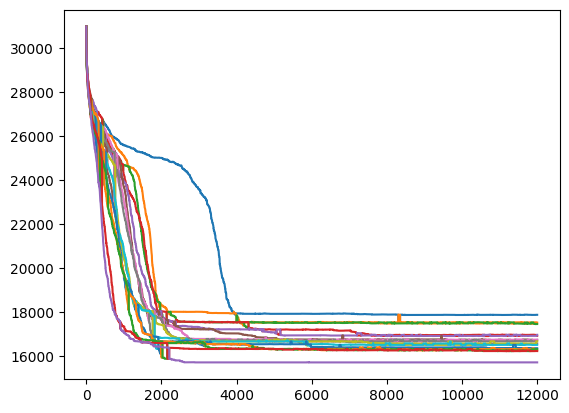

In [100]:
for k_nt in range(N_t):
    plt.plot(energies_pasos[0,k_nt])

In [27]:
Pasos = len(P_store[:,0,0])
for i_pasos in range(Pasos):
    print(P_store[i_pasos,7,:,:10])
    print()

[[64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [63. 11.  3. 43. 44. 64. 59. 25. 54. 27.]
 [64. 12.  2. 43. 44. 63. 60. 25. 53. 29.]]

[[64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [63. 11.  3. 43. 44. 64. 59. 25. 54. 27.]
 [64. 12.  2. 43. 44. 63. 60. 25. 53. 29.]]

[[64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [63. 11.  3. 43. 44. 64. 59. 25. 54. 27.]
 [64. 12.  2. 43. 44. 63. 60. 25. 53. 29.]]

[[64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [63. 11.  3. 43. 44. 64. 59. 25. 54. 27.]
 [64. 12.  2. 43. 44. 63. 60. 25. 53. 29.]]

[[64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [63. 11.  3. 43. 44. 64. 59. 25. 54. 27.]
 [64. 12.  2. 43. 44. 63. 60. 25. 53. 29.]]

[[64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [64. 12.  2. 43. 44. 63. 60. 25. 53. 26.]
 [63. 11.  3. 43. 44. 64. 59. 25. 54. 27.]
 

In [25]:
P_store.shape

(160, 15, 4, 224)